# STOFS Event-based Skill Assessment 
Here we are reading, subsetting and visualizing the forecast and nowcast data from STOFS-2D-Global and STOFS-3D-Atl data. We also read and plot reported water levels at CO-OPS stations. 

In [74]:
import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
from datetime import datetime, timedelta, timezone
import searvey
from searvey.coops import get_coops_stations
from searvey._coops_api import fetch_coops_station
import tempfile
import pygrib
import math
from typing import List


# Input Parameters for Event Analysis


- **bucket_name_2d**: Name of the S3 bucket storing STOFS-2d-global data.
- **bucket_name_3d**: Name of the S3 bucket storing STOFS-3d-Atl data.
- **date_range**: Date range in YYYYMMDD format for analysis.
- **cycles_2d**: List of cycle times (in HH format, e.g., 00, 06, 12, 18) for STOFS-2d-Global forecasts.
- **Hours_before_landfall**: Number of hours before landfall for analysis.
- **Region**: Bounding box string defining the region of interest (min_lon, max_lon, min_lat, max_lat).
- **Event_name**: Name of the storm for hurricane track data extraction and file naming.
- **STOFS_file_2d**: File from STOFS-2d-Global for water level skill assessment.
- **STOFS_file_3d**: File from STOFS-3d-Atl for water level skill assessment.




In [148]:
# Info of STOFS data

bucket_name_2d   = 'noaa-gestofs-pds'
bucket_name_3d  = 'noaa-nos-stofs3d-pds'
date_range         = ['20240707','20240709']  
landfall_time_step = 32 # hours after start date from the date range input
cycles_2d        = ['00', '06', '12', '18']  
Hours_before_landfall = 48 # For reading Forecast data
Region       = (-95.5, -94, 28, 30) # (longitude_min, longitude_max, latitude_min, latitude_max)
Event_name = 'Hurricane Beryl'
STOFS_file_2d   = 'points.cwl'
STOFS_file_3d   = 'points.cwl'


# Future Development Note: Hurricane Track Visualization


For future developments, consider adding code to read and visualize the best hurricane track.


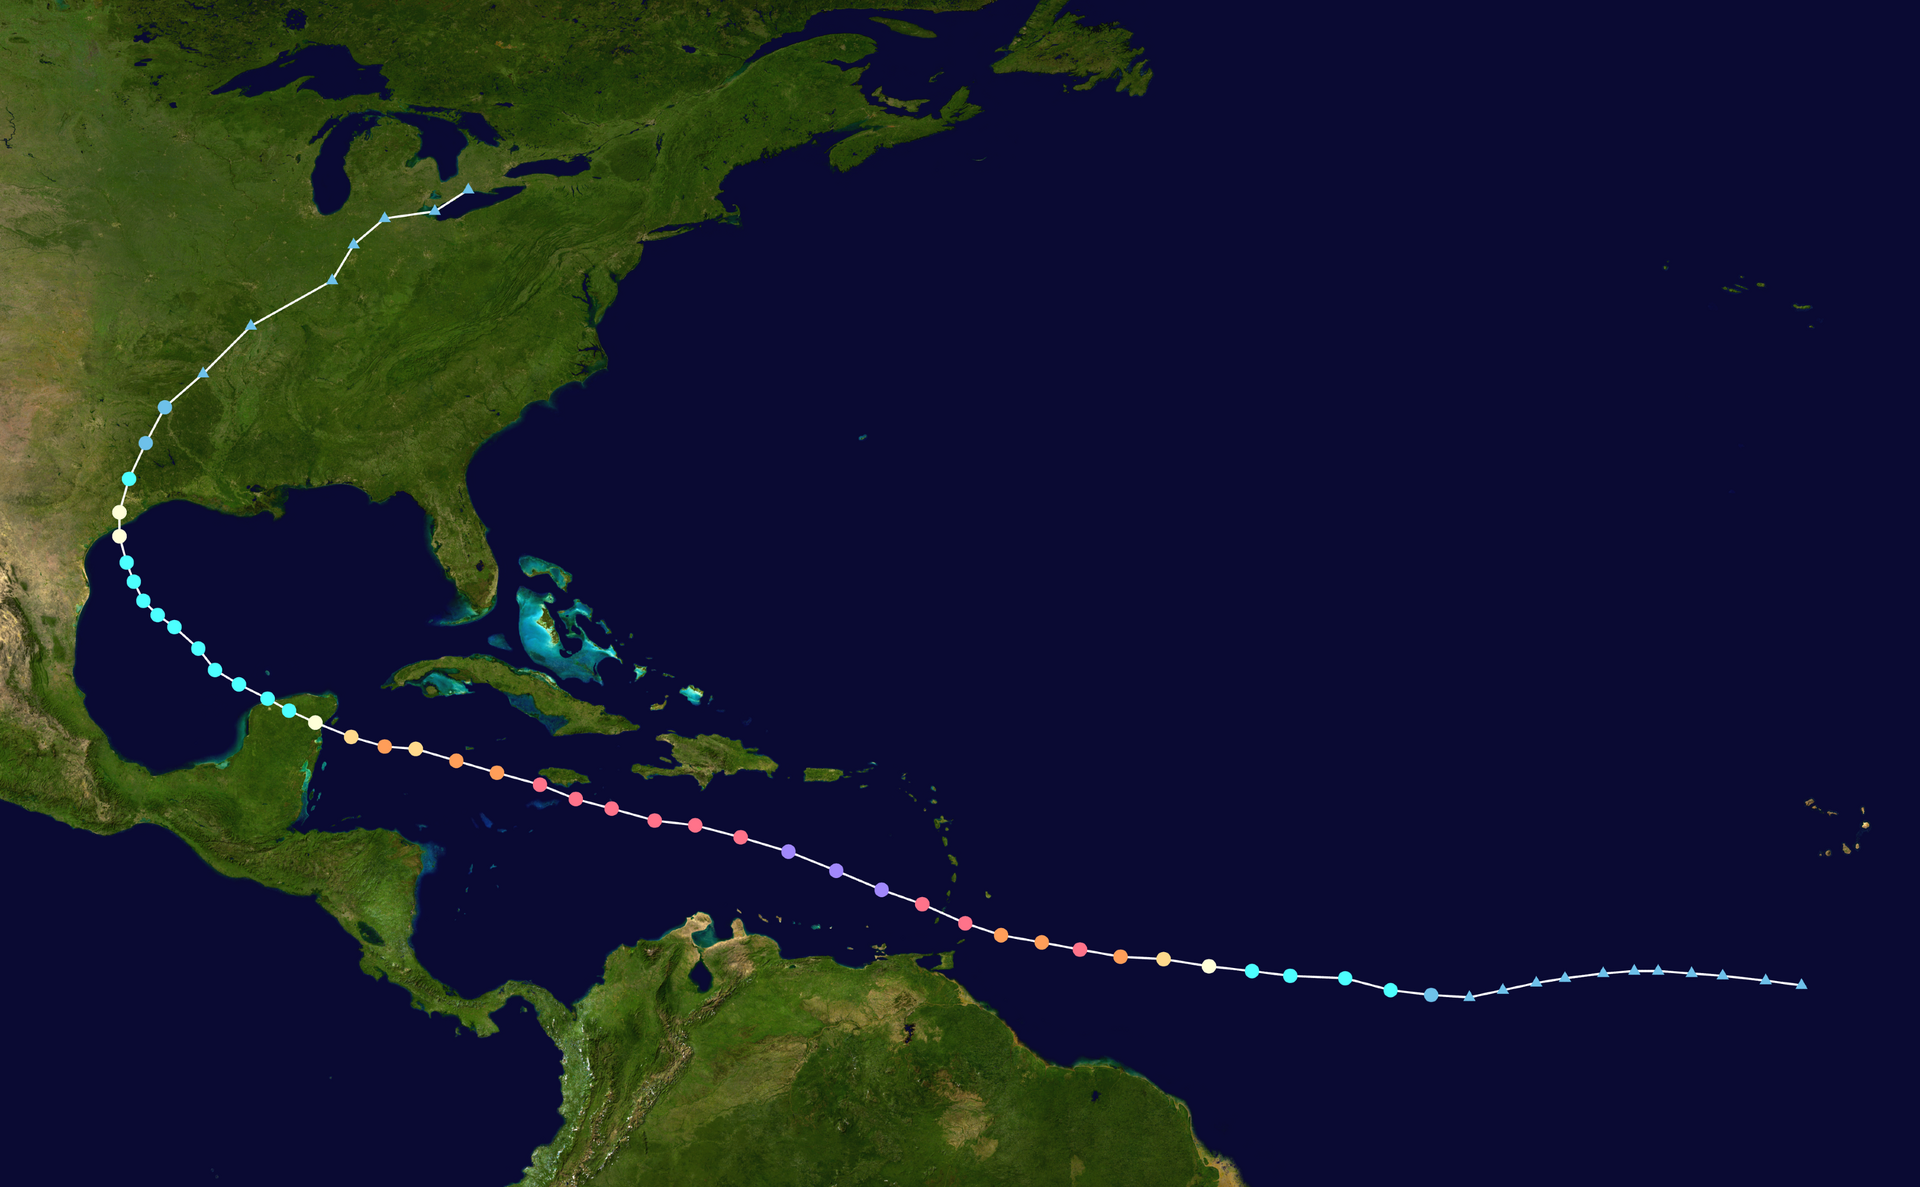

*Note: Image sourced from [Wikipedia](https://en.wikipedia.org/wiki/Hurricane_Beryl) for Hurricane Beryl track visualization.*






# Read STOFS-2d-Global Nowcast Data on the Fly

In [149]:
def read_netcdf_from_s3(bucket_name, key):
    """
    Function to read a NetCDF file from an S3 bucket using thalassa API.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])
    return ds



In [151]:
# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_2d_all_list = []
for date in dates:
    for cycle in cycles_2d:
         base_key = f'stofs_2d_glo.{date}'
         filename = f't{cycle}z.{STOFS_file_2d}.nc'
         key = f'{base_key}/stofs_2d_glo.{filename}'
         dataset_2d = read_netcdf_from_s3(bucket_name, key)
         nowcast_2d = dataset_2d.isel(time=slice(0, 60)) # the first 6 hr (60 time steps are the nowcast data in STOFS-2D-Global)
         nowcast_2d_all_list.append(nowcast_2d)
        
nowcast_2d_all = xr.concat(nowcast_2d_all_list, dim='time')

nowcast_2d_all   # a xarray data set containing all the nowcast data


<xarray.Dataset> Size: 120MB
Dimensions:       (time: 960, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 8kB 2024-07-06T18:06:00 ... 2024-07-1...
Dimensions without coordinates: station
Data variables:
    station_name  (time, station) |S50 81MB b'PSBM1 SOUS41 8410140 ME Eastpor...
    x             (time, station) float64 13MB -66.98 -67.2 ... -51.01 -25.5
    y             (time, station) float64 13MB 44.9 44.65 44.39 ... 58.96 58.96
    zeta          (time, station) float64 13MB 1.207 0.8957 ... -0.6726 -0.0352
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024070700 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [78]:
# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_2d_all_list = []
for date in dates:
    for cycle in cycles_2d:
         base_key = f'stofs_2d_glo.{date}'
         filename = f't{cycle}z.{STOFS_file_2d}.nc'
         key = f'{base_key}/stofs_2d_glo.{filename}'
         try:
            dataset_2d = read_netcdf_from_s3(bucket_name, key)


            # Check if dataset_2d exists and has data
            if dataset_2d is not None:
                nowcast_2d = dataset_2d.isel(time=slice(0, 60))  # First 60 time steps (nowcast data)
                nowcast_2d_all_list.append(nowcast_2d)
         except Exception as e:
            print(f'Error reading file {key} from S3: {str(e)}')

nowcast_2d_all_out_of_range = xr.concat(nowcast_2d_all_list, dim='time')

nowcast_2d_all = nowcast_2d_all_out_of_range.sel(time=slice(start_date, end_date))    # a xarray data set containing all the nowcast data for the specidified range

nowcast_2d_all

<xarray.Dataset> Size: 90MB
Dimensions:       (time: 721, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 6kB 2024-07-07 ... 2024-07-10
Dimensions without coordinates: station
Data variables:
    station_name  (time, station) |S50 61MB b'PSBM1 SOUS41 8410140 ME Eastpor...
    x             (time, station) float64 10MB -66.98 -67.2 ... -51.01 -25.5
    y             (time, station) float64 10MB 44.9 44.65 44.39 ... 58.96 58.96
    zeta          (time, station) float64 10MB -0.891 -0.6393 ... 1.024 -0.1225
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024070700 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Read STOFS-3d-Atlantic Nowcast Data on the Fly

In [153]:
# Read STOFS-3d-Atlantic

bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_3d_all_list = []
for date in dates:
         base_key = f'stofs_3d_atl.{date}'
         filename = 't12z.points.cwl.nc'
         key = f'STOFS-3D-Atl/{base_key}/stofs_3d_atl.{filename}'
         try:
            dataset_3d = read_netcdf_from_s3(bucket_name, key)


            # Check if dataset_2d exists and has data
            if dataset_3d is not None:
                nowcast_3d = dataset_3d.isel(time=slice(0, 240))  # the first 24 hr (240 time steps are the nowcast data)
                nowcast_3d_all_list.append(nowcast_3d)
         except Exception as e:
            print(f'Error reading file {key} from S3: {str(e)}')
       

nowcast_3d_all_out_of_range = xr.concat(nowcast_3d_all_list, dim='time')

nowcast_3d_all = nowcast_3d_all_out_of_range.sel(time=slice(start_date, end_date))    # a xarray data set containing all the nowcast data for the specidified range

nowcast_3d_all   # a xarray data set containing all the nowcast data


<xarray.Dataset> Size: 8MB
Dimensions:       (time: 721, station: 108)
Coordinates:
  * time          (time) datetime64[ns] 6kB 2024-07-07 ... 2024-07-10
Dimensions without coordinates: station
Data variables:
    zeta          (time, station) float64 623kB -1.845 -1.11 ... 0.0653 0.4791
    station_name  (time, station) |S50 4MB b'PSBM1 SOUS41 8410140 ME Eastport...
    x             (time, station) float64 623kB 44.9 44.66 43.66 ... 26.06 27.83
    y             (time, station) float64 623kB -66.98 -67.2 ... -97.22 -97.49
    u             (time, station) float64 623kB -0.7698 -0.1099 ... -999.0
    v             (time, station) float64 623kB -0.6133 0.06315 ... -999.0
    salinity      (time, station) float64 623kB 28.64 31.99 ... 32.37 -999.0
    temperature   (time, station) float64 623kB 11.89 10.4 ... 29.99 -999.0
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/
    history:     Sun Jul  7 18:04:48 2024: ncap2 -O -F -S /lfs/h1/ops/prod/pa...
    NCO:         netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net...

# Find all the CO-OPs stations in the region using searvey

In [154]:
bbox = shapely.box(Region[0], Region[2], Region[1], Region[3])
station_ds= searvey.coops.coops_product_within_region('water_level', region=bbox, start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9))
station_ds


/tmp/ipykernel_13135/811290957.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) coops_product_within_region. (This function is deprecated and will be removed in the future. Replace it with `fetch_coops_station`.) -- Deprecated since version 0.4.0.
  station_ds= searvey.coops.coops_product_within_region('water_level', region=bbox, start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9)


<xarray.Dataset> Size: 239kB
Dimensions:  (t: 960, nos_id: 10)
Coordinates:
  * t        (t) datetime64[ns] 8kB 2024-07-06T18:06:00 ... 2024-07-10T18:00:00
  * nos_id   (nos_id) object 80B '8771972' '8772471' ... '8770777' '8771450'
    nws_id   (nos_id) <U5 200B 'LUIT2' 'FPST2' 'EPTT2' ... 'NCHT2' 'GTOT2'
    x        (nos_id) float64 80B -95.11 -95.29 -94.92 ... -94.99 -95.27 -94.79
    y        (nos_id) float64 80B 29.09 28.94 29.48 29.51 ... 29.68 29.73 29.31
Data variables:
    v        (nos_id, t) float32 38kB 1.696 1.701 1.697 ... 1.745 1.739 1.728
    s        (nos_id, t) float32 38kB 0.018 0.022 0.021 ... 0.01 0.007 0.004
    f        (nos_id, t) object 77kB '1,0,0,0' '0,0,0,0' ... '0,0,0,0' '1,0,0,0'
    q        (nos_id, t) object 77kB 'p' 'p' 'p' 'p' 'p' ... 'p' 'p' 'p' 'p' 'p'

# Find CO-OPS station in STOFS-2D-Global station list

In [155]:
# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points = []
x_values = []
y_values = []
names = []


# Loop over stations and extract zeta if any search string is found in the station name

station_id = np.sort(station_ds['nos_id'].values)

for nos_id in station_id:
  
    for station_index in range(len(nowcast_2d_all.station)):
        station_name = nowcast_2d_all.station_name[0,station_index].item().decode('utf-8').strip()
        if (nos_id in station_name):
           zeta_values = nowcast_2d_all.zeta[:, station_index]  # Extract zeta values for the current station
           x = nowcast_2d_all.x[0, station_index]
           y = nowcast_2d_all.y[0, station_index]
           # Save the availilbe stations in the station list
           nos_id_points.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
all_zeta_values = np.concatenate(zeta_values_list, axis=0)

all_zeta_values = np.reshape(all_zeta_values, (int(len(all_zeta_values)/len(nowcast_2d_all.time)),len(nowcast_2d_all.time)))
nos_id_points , names

(['8770613',
  '8770777',
  '8770808',
  '8770971',
  '8771013',
  '8771341',
  '8771450',
  '8771486',
  '8771972'],
 ['MGPT2 SOUS42 8770613 TX Morgans Point, Barbours Cu',
  'NCHT2 SOUS42 8770777 TX Manchester',
  'HIST2 SOUS42 8770808 TX High Island',
  'RLOT2 SOUS42 8770971 TX Rollover Pass',
  'EPTT2 SOUS42 8771013 TX Eagle Point, Galveston Bay',
  'GNJT2 SOUS42 8771341 TX Galveston Bay Entrance, No',
  'GTOT2 SOUS42 8771450 TX Galveston Pier 21',
  'GRRT2 SOUS42 8771486 TX Galveston Railroad Bridge',
  'LUIT2 SOUS42 8771972 TX San Luis Pass'])

# Plot the stations for STOFS-2d-Global


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
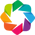

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [156]:
hv.extension("bokeh")

# Set some defaults for the visualization of the graphs
hvopts.defaults(
    hvopts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
    ),
)


# The tiles is using the tiling service from Open Street maps
tiles =  api.get_tiles() 

stations = (x_values,y_values)
kb = gv.Points(stations).opts(color="red", marker="circle_dot", size=5)


layout = tiles * kb 
layout

# Find CO-OPS station in STOFS-3D-Atlantic station list

In [157]:
# Create an empty list to collect zeta values
zeta_values_list_3d = []
nos_id_points_3d = []
x_values_3d = []
y_values_3d = []
names_3d = []


# Loop over stations and extract zeta if any search string is found in the station name

for nos_id in station_id:
    
     for station_index in range(len(nowcast_3d_all.station)):
        station_name = nowcast_3d_all.station_name[0,station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           zeta_values = nowcast_3d_all.zeta[:, station_index]  # Extract zeta values for the current station
           x = station_ds['x'][station_ds['nos_id']==nos_id]
           y = station_ds['y'][station_ds['nos_id']==nos_id]
           # Save the availilbe stations in the station list
           nos_id_points_3d.append(nos_id)
           zeta_values_list_3d.append(zeta_values)
           x_values_3d.append(x.item())
           y_values_3d.append(y.item())
           names_3d.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
all_zeta_values_3d = np.concatenate(zeta_values_list_3d, axis=0)

all_zeta_values_3d = np.reshape(all_zeta_values_3d, ( int(len(all_zeta_values_3d)/len(nowcast_3d_all.time)),len(nowcast_3d_all.time)))
nos_id_points_3d , names_3d


(['8770613',
  '8770777',
  '8770808',
  '8770971',
  '8771341',
  '8771450',
  '8771486',
  '8771972'],
 ['MGPT2 SOUS42 8770613 TX Morgans',
  'NCHT2 SOUS42 8770777 TX Manchester',
  'HIST2 SOUS42 8770808 TX High',
  'RLOT2 SOUS42 8770971 TX Rollover',
  'GNJT2 SOUS42 8771341 TX Galveston',
  'GTOT2 SOUS42 8771450 TX Galveston',
  'GRRT2 SOUS42 8771486 TX Galveston',
  'LUIT2 SOUS42 8771972 TX San Luis Pass'])

# Plot the stations for STOFS-3d-Atlantic

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
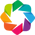

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [158]:
hv.extension("bokeh")
# Set some defaults for the visualization of the graphs
hvopts.defaults(
    hvopts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
    ),
)


# The tiles is using the tiling service from Open Street maps
tiles_3d =  api.get_tiles() 

stations_3d = (x_values_3d,y_values_3d)
kb_3d = gv.Points(stations_3d).opts(color="red", marker="circle_dot", size=5)


layout_3d = tiles_3d * kb_3d 
layout_3d

# Read Observation data for STOFS-2D-Global

In [159]:

# Initialize an empty DataFrame to store the data
Observation = []

# Loop over each nos_id
for nos_id in nos_id_points:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='MSL')
      

       # Add the data for the current station to the result DataFrame
       Observation.append(station_df['v'].values)



# Read Observation data for STOFS-3D-Atlantic

In [160]:

# Initialize an empty DataFrame to store the data
Observation_3d = []

# Loop over each nos_id
for nos_id in nos_id_points_3d:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='NAVD')
      

       # Add the data for the current station to the result DataFrame
       Observation_3d.append(station_df['v'].values)



# Plot Nowcast Time series STOFS-2D-Global

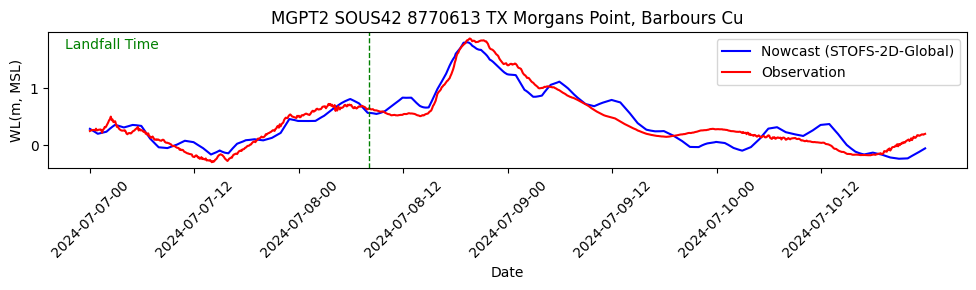

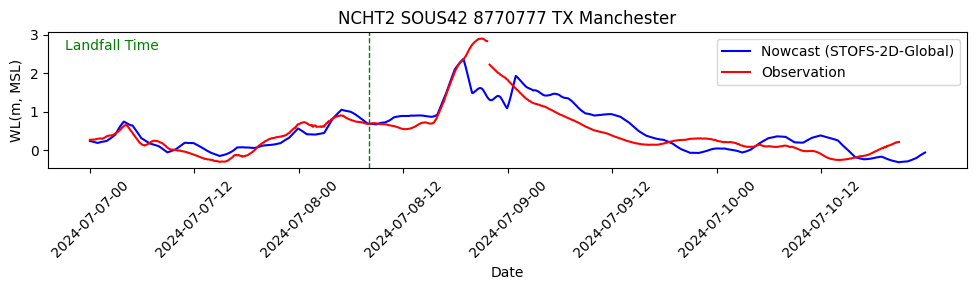

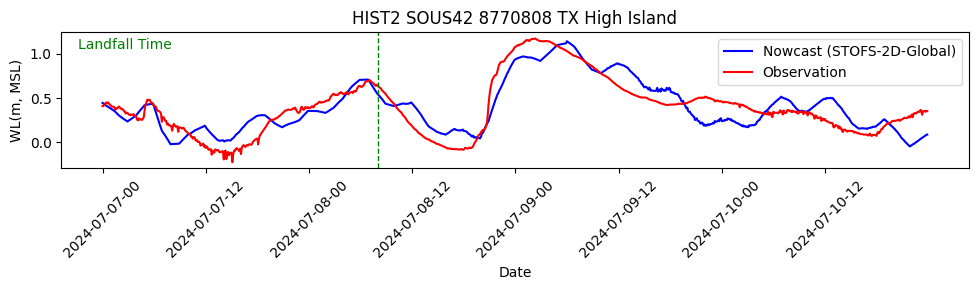

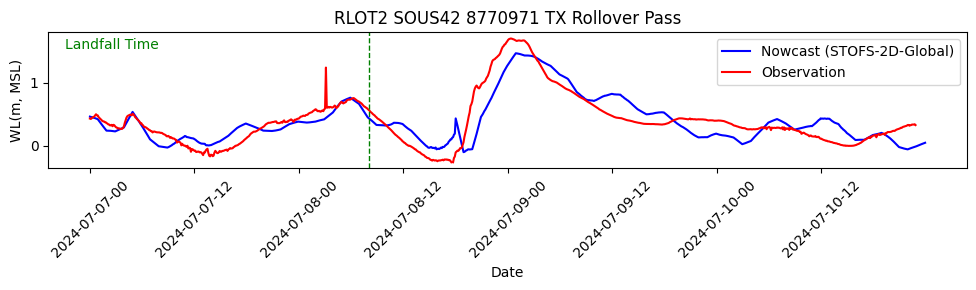

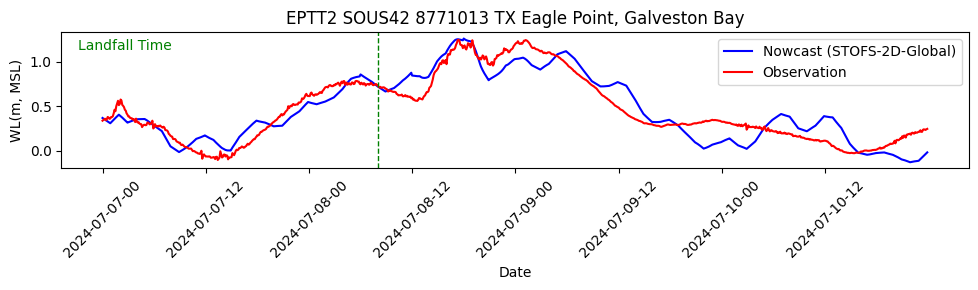

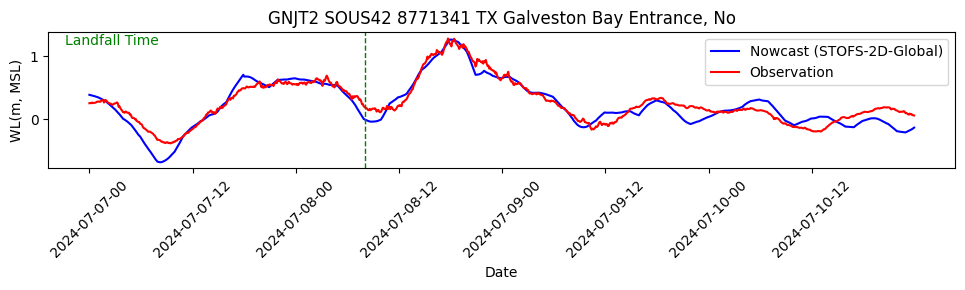

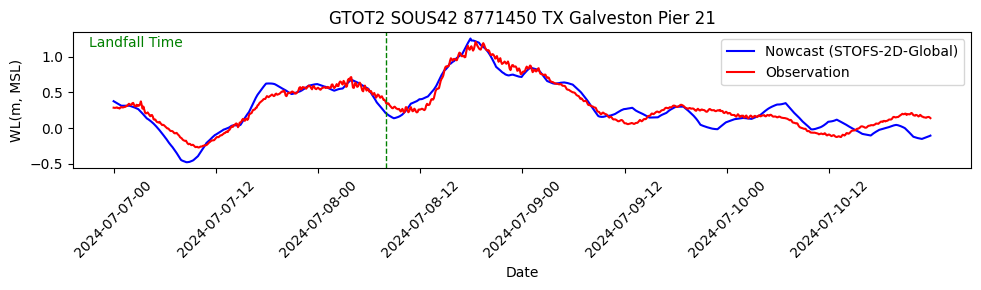

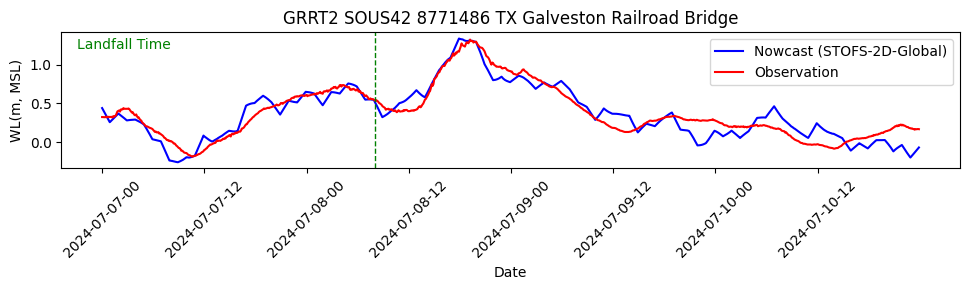

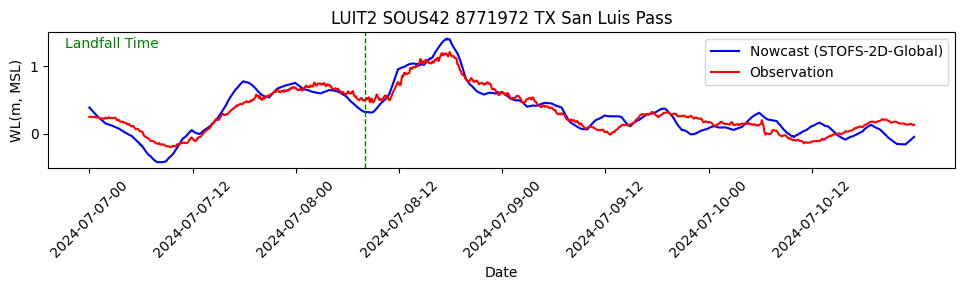

In [161]:

def convert_to_datetime(time_step):
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    time_delta = timedelta(minutes=6)  
    return start_date + time_step * time_delta


index = 0

for nos_id in nos_id_points:
    
    fig, ax = plt.subplots(figsize=(10, 3))
       
    ax.plot(all_zeta_values[index,:], label='Nowcast (STOFS-2D-Global)', color='blue')
    ax.plot(Observation[index][0], label='Observation', color='red')


    ax.set_title(names[index])
        
    ax.set_xlabel('Date')

   
    # Set x ticks and labels
    ax.set_xticks(range(0, len(all_zeta_values[index, :]), 120)) 
    time_steps = range(0, len(all_zeta_values[index, :]))
    time_labels = [convert_to_datetime(step) for step in time_steps]

    selected_dates = time_labels[::120]
    ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)

    ax.axvline(x=landfall_time_step*10, color='green', linestyle='--', linewidth=1)
    ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
    ax.set_ylabel('WL(m, MSL)')
    ax.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()
    index = index+1

# Plot Nowcast Time series STOFS-3D-Atlantic

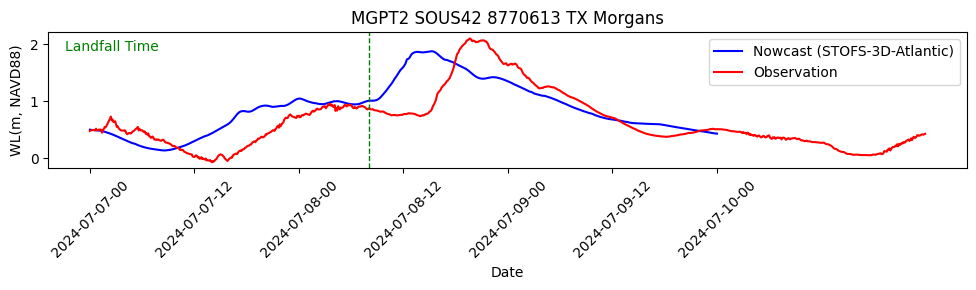

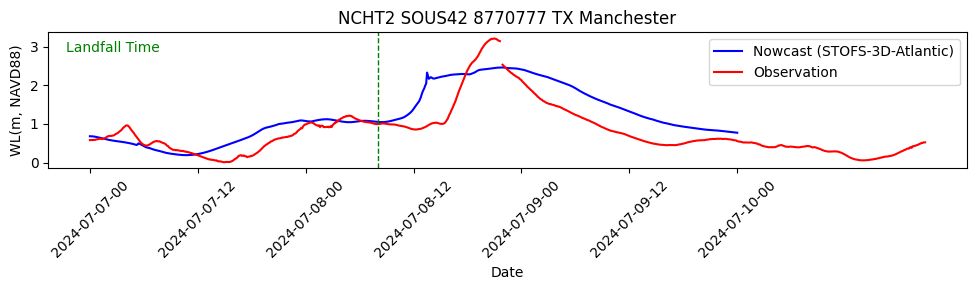

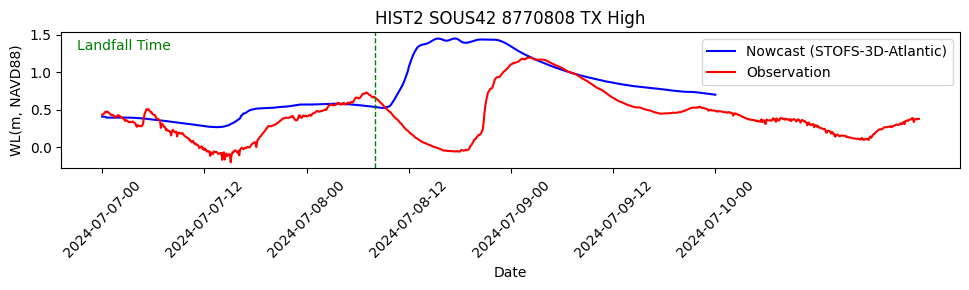

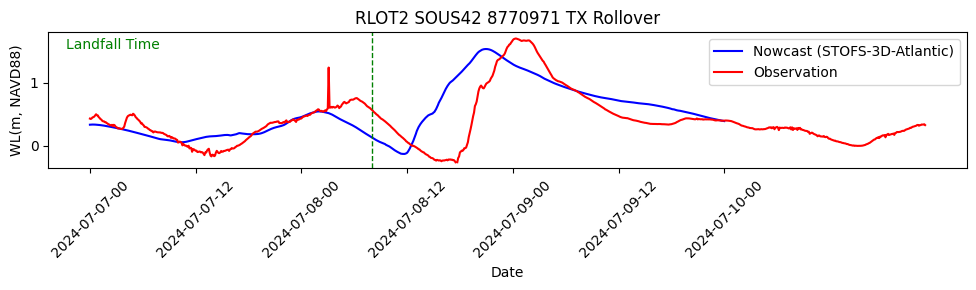

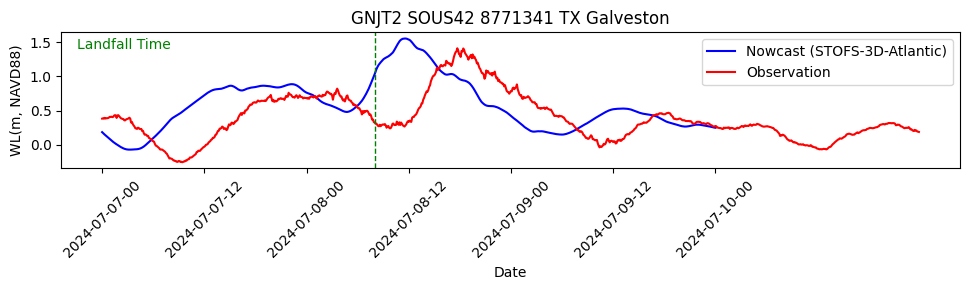

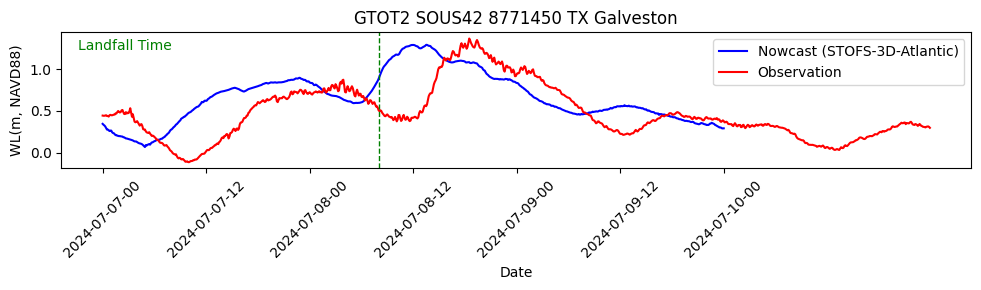

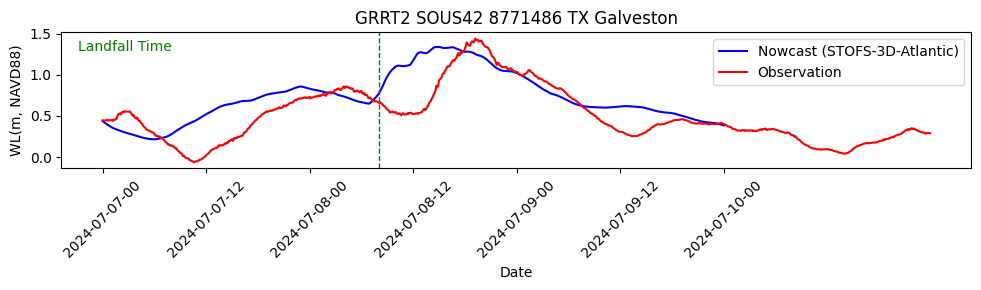

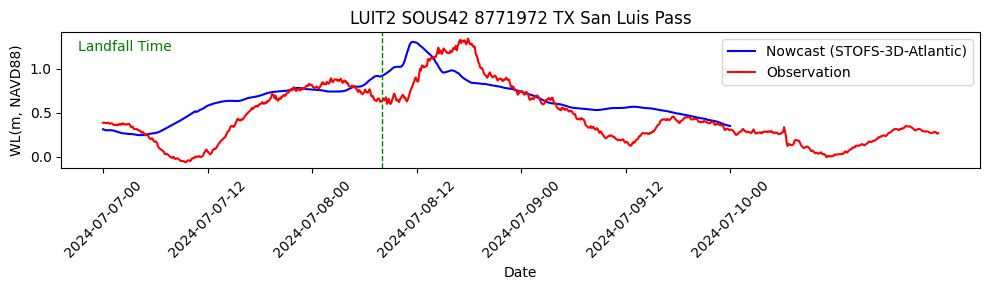

In [162]:

def convert_to_datetime(time_step):
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    time_delta = timedelta(minutes=6)  
    return start_date + time_step * time_delta



index_3d = 0 

for nos_id in nos_id_points_3d:
    
    fig, ax = plt.subplots(figsize=(10, 3))
       
    ax.plot(all_zeta_values_3d[index_3d,:], label='Nowcast (STOFS-3D-Atlantic)', color='blue')        
    ax.plot(Observation_3d[index_3d][0], label='Observation', color='red')
    ax.set_title(names_3d[index_3d])
        
    ax.set_xlabel('Date')
    
    # Set x ticks and labels
    ax.set_xticks(range(0, len(all_zeta_values_3d[index_3d, :]), 120)) 
    time_steps = range(0, len(all_zeta_values_3d[index_3d, :]))
    time_labels = [convert_to_datetime(step) for step in time_steps]

    
    # Calculate the landfall time step
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
    forecast_3d_landfall_time_step = None 
    
    for step, time_label in zip(time_steps, time_labels): 

        if time_label.replace(tzinfo = None) == landfall_datetime:
            nowcast_3d_landfall_time_step = step 
            break   
            
    selected_dates = time_labels[::120]
    ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
            
    ax.axvline(x=forecast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
    ax.text(forecast_3d_landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')


    ax.axvline(x=landfall_time_step*10, color='green', linestyle='--', linewidth=1)
    ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
    ax.set_ylabel('WL(m, NAVD88)')
    ax.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()
    index_3d = index_3d+1 


# Convert STOFS-3D-Atl datum to MSL and plot both time series in one figure

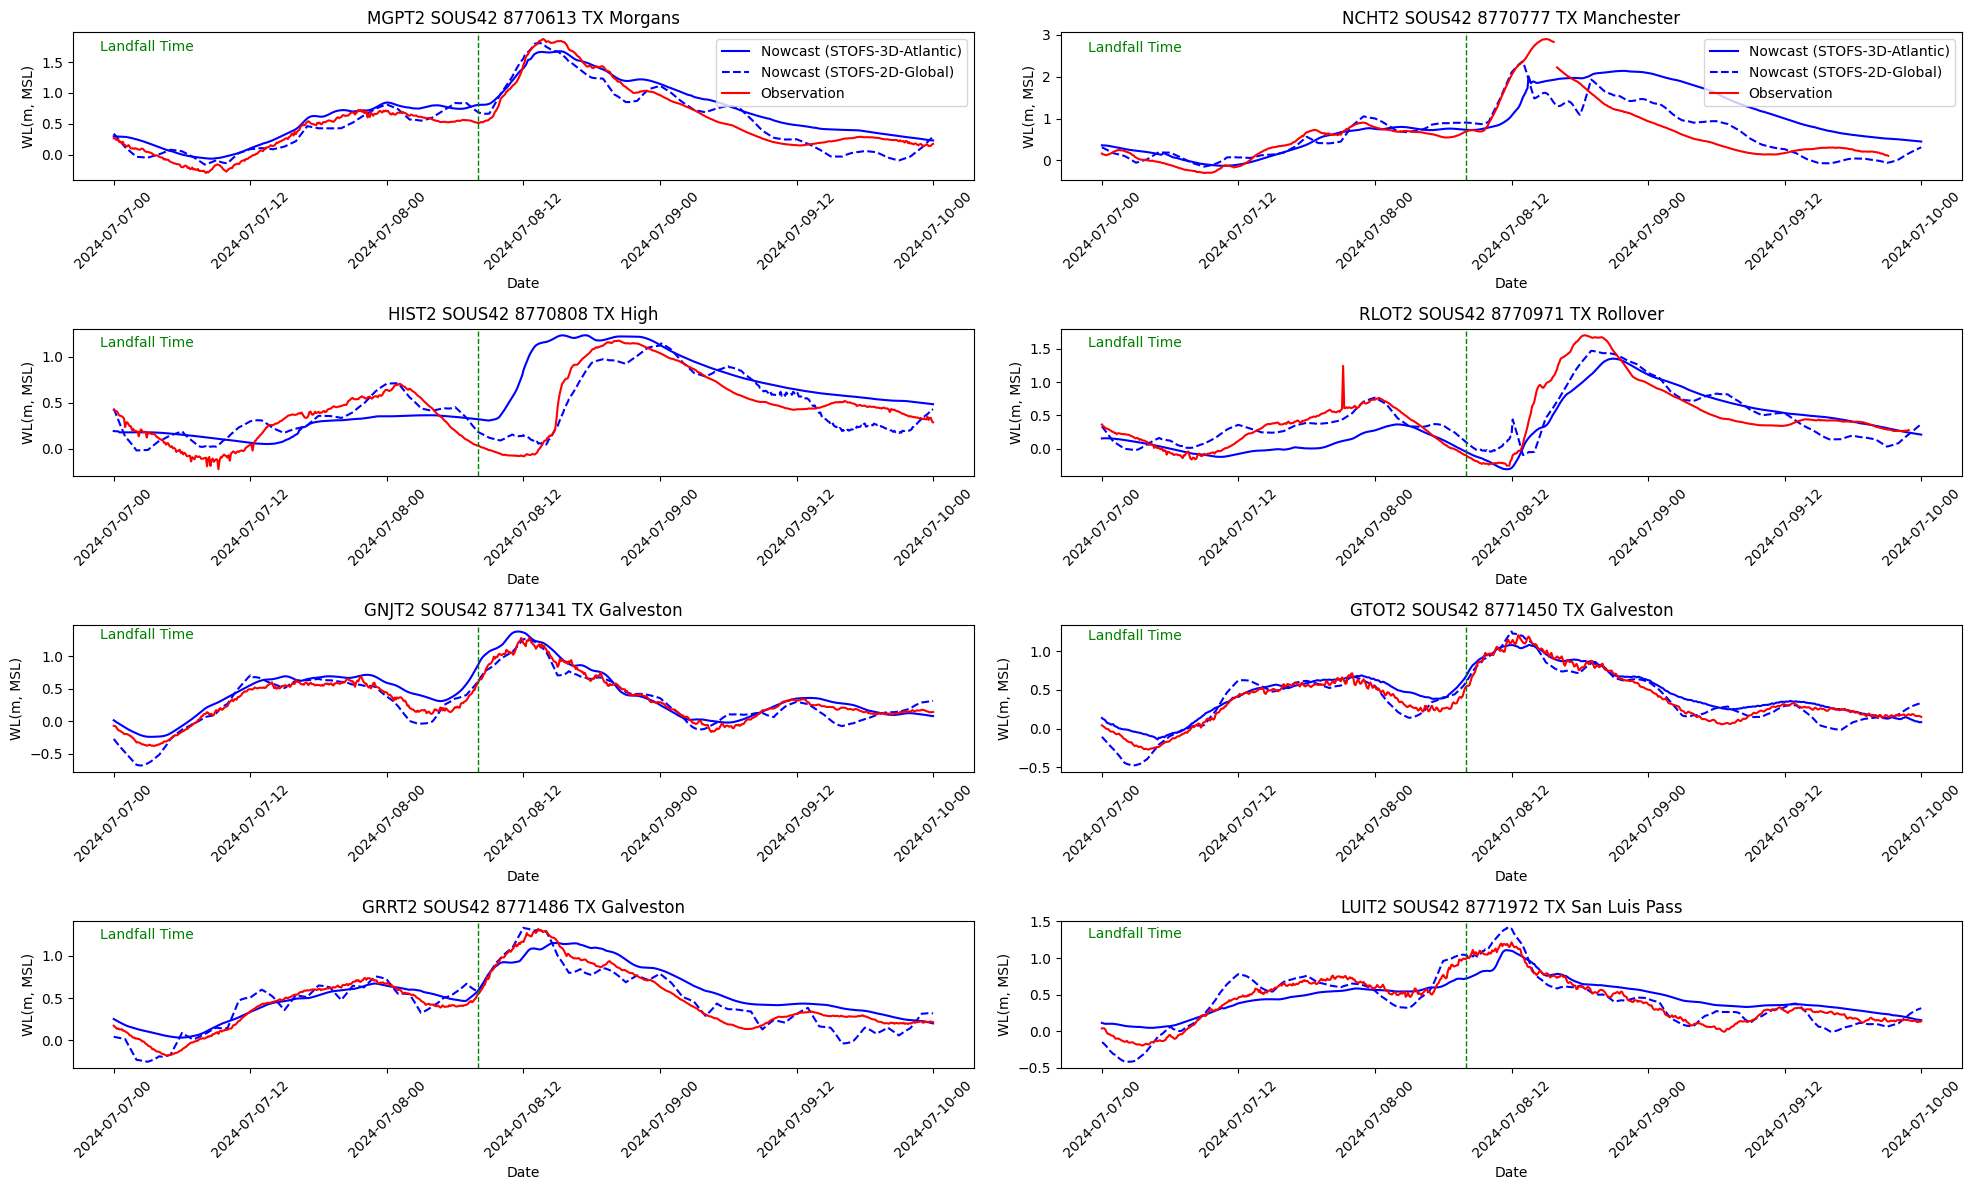

In [16]:

# Convert STOFS-3D-Atl datum to MSL

# From VDatum Package
Conversion_values = [-0.201, -0.322, -0.215, -0.185, -0.169, -0.209, -0.186, -0.200]
'''
all_zeta_values_3d_MSL = all_zeta_values_3d

for index in range(0, all_zeta_values_3d.shape[0]):
    all_zeta_values_3d_MSL[index] = all_zeta_values_3d[index] + Conversion_values[index]
'''

def convert_to_datetime(time_step, date_range):
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 12))  # 4 rows, 2 columns


index_3d = 0


for row in range(4):  
    for col in range(2):  
        ax = axs[row, col]
        if index_3d < len(nos_id_points_3d):
            ax.plot(all_zeta_values_3d[index_3d, :]+Conversion_values[index_3d], label='Nowcast (STOFS-3D-Atlantic)', color='blue')

            for i in range(0,len(nos_id_points)):
                if nos_id_points[i]== nos_id_points_3d[index_3d]:
                   index_2d = i
                   break
            
            ax.plot(all_zeta_values[i, :], label='Nowcast (STOFS-2D-Global)', color='blue', linestyle='dashed')
            ax.plot(Observation[i][0], label='Observation', color='red')
            
            ax.set_title(names_3d[index_3d])
            
            ax.set_xlabel('Date')
            
            # Set x ticks and labels
            ax.set_xticks(range(0, len(all_zeta_values_3d[index_3d, :]), 120))
            time_steps = range(0, len(all_zeta_values_3d[index_3d, :]))
            time_labels = [convert_to_datetime(step, date_range) for step in time_steps]
            selected_dates = time_labels[::120]
            ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
            
            ax.axvline(x=landfall_time_step*10, color='green', linestyle='--', linewidth=1)
            ax.text(landfall_time_step*0.9, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
            
            ax.set_ylabel('WL(m, MSL)')
            if row == 0 :
                ax.legend(loc='upper right')
        
        index_3d += 1


plt.tight_layout()
plt.savefig(f'nowcast_{Event_name}')  # Save the figure
plt.show()




# Read STOFS-2d-Global Forecast Data on the Fly 

In [89]:
# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')

# Find the Forecast cycle
date_H = int((start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%H'))

cycle = None
for num in cycles_2d:
    if int(num) < date_H:
        if cycle is None or int(num) > cycle:
            cycle = int(num)
cycle = f'{cycle:02}'


base_key = f'stofs_2d_glo.{date}'
filename = f't{cycle}z.{STOFS_file_2d}.nc'
key = f'{base_key}/stofs_2d_glo.{filename}'
forecast_2d = read_netcdf_from_s3(bucket_name, key)

forecast_2d

<xarray.Dataset> Size: 25MB
Dimensions:       (time: 1860, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 15kB 2024-07-06T00:06:00 ... 2024-07-...
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 84kB ...
    x             (station) float64 14kB ...
    y             (station) float64 14kB ...
    zeta          (time, station) float64 25MB ...
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024070606 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Read STOFS-3d-Atlantic Forecast Data on the Fly 

In [90]:
# Read STOFS-3d-Atlantic

bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)


# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')


base_key = f'stofs_3d_atl.{date}'
filename = 't12z.points.cwl.nc'
key = f'STOFS-3D-Atl/{base_key}/stofs_3d_atl.{filename}'
forecast_3d = read_netcdf_from_s3(bucket_name, key)

forecast_3d


<xarray.Dataset> Size: 5MB
Dimensions:       (time: 1200, station: 108)
Coordinates:
  * time          (time) datetime64[ns] 10kB 2024-07-05T12:06:00 ... 2024-07-...
Dimensions without coordinates: station
Data variables:
    zeta          (time, station) float64 1MB ...
    station_name  (station) |S50 5kB ...
    x             (station) float64 864B ...
    y             (station) float64 864B ...
    u             (time, station) float64 1MB ...
    v             (time, station) float64 1MB ...
    salinity      (time, station) float64 1MB ...
    temperature   (time, station) float64 1MB ...
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/
    history:     Sat Jul  6 18:04:55 2024: ncap2 -O -F -S /lfs/h1/ops/prod/pa...
    NCO:         netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net...

# Collect Forecast data at CO-OPS stations in STOFS-2D-Global station list

In [93]:
# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points = []
x_values = []
y_values = []
names = []


# Loop over stations and extract zeta if any search string is found in the station name


    
for nos_id in station_id:
  

   for station_index in range(len(forecast_2d.station)):
        station_name = forecast_2d.station_name[station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           print(nos_id)
           zeta_values = forecast_2d.zeta[:, station_index]  # Extract zeta values for the current station
           x = forecast_2d.x[station_index]
           y = forecast_2d.y[station_index]
           # Save the availilbe stations in the station list
           nos_id_points.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
forecast_all_zeta_values = np.concatenate(zeta_values_list, axis=0)

forecast_all_zeta_values = np.reshape(forecast_all_zeta_values, (int(len(forecast_all_zeta_values)/len(forecast_2d.time)),len(forecast_2d.time)))


8770613
8770777
8770808
8770971
8771013
8771341
8771450
8771486
8771972


# Collect Forecast data at CO-OPS stations in STOFS-3D_Atlantic station list

In [94]:
# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points_3d = []
x_values = []
y_values = []
names_3d = []


# Loop over stations and extract zeta if any search string is found in the station name

    
for nos_id in station_id:
    
    for station_index in range(len(forecast_3d.station)):
        station_name = forecast_3d.station_name[station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           print(nos_id)
           zeta_values = forecast_3d.zeta[:, station_index]  # Extract zeta values for the current station
           x = forecast_3d.x[station_index]
           y = forecast_3d.y[station_index]
           # Save the availilbe stations in the station list
           nos_id_points_3d.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names_3d.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
forecast_3d_all_zeta_values = np.concatenate(zeta_values_list, axis=0)

forecast_3d_all_zeta_values = np.reshape(forecast_3d_all_zeta_values, (int(len(forecast_3d_all_zeta_values)/len(forecast_3d.time)),len(forecast_3d.time)))


8770613
8770777
8770808
8770971
8771341
8771450
8771486
8771972


# Collect the observation data for STOFS-2D-Global

In [114]:

# Initialize an empty DataFrame to store the data
Observation_2d_forecast = []

# Loop over each nos_id
for nos_id in nos_id_points:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(forecast_2d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(forecast_2d.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='MSL')
      

       # Add the data for the current station to the result DataFrame
       Observation_2d_forecast.append(station_df['v'].values)



[array([[0.149, 0.16 , 0.154, ..., 0.066, 0.074, 0.075]], dtype=float32),
 array([[0.203, 0.204, 0.199, ..., 0.106, 0.108, 0.104]], dtype=float32),
 array([[0.274, 0.276, 0.278, ..., 0.256, 0.257, 0.245]], dtype=float32),
 array([[0.284, 0.272, 0.257, ..., 0.27 , 0.244, 0.281]], dtype=float32),
 array([[0.149, 0.134, 0.126, ..., 0.193, 0.178, 0.16 ]], dtype=float32),
 array([[-0.257, -0.276, -0.283, ...,  0.035,  0.026,  0.024]],
       dtype=float32),
 array([[-0.128, -0.138, -0.153, ...,  0.062,  0.068,  0.08 ]],
       dtype=float32),
 array([[-0.003, -0.012, -0.028, ...,  0.12 ,  0.119,  0.122]],
       dtype=float32),
 array([[-0.144, -0.143, -0.152, ...,  0.07 ,  0.065,  0.048]],
       dtype=float32)]

# Collect the observation data for STOFS-3D-Atlantic

In [96]:

# Initialize an empty DataFrame to store the data
Observation_3d_forecast = []

# Loop over each nos_id
for nos_id in nos_id_points_3d:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(forecast_3d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(forecast_3d.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='NAVD')
      

       # Add the data for the current station to the result DataFrame
       Observation_3d_forecast.append(station_df['v'].values)

# Plot Forecast for STOFS-2D-Global

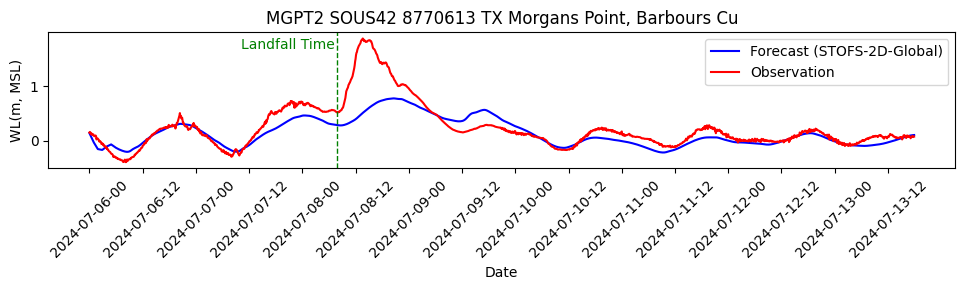

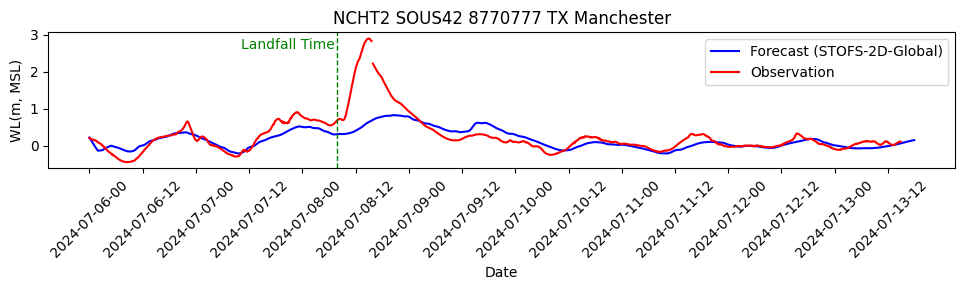

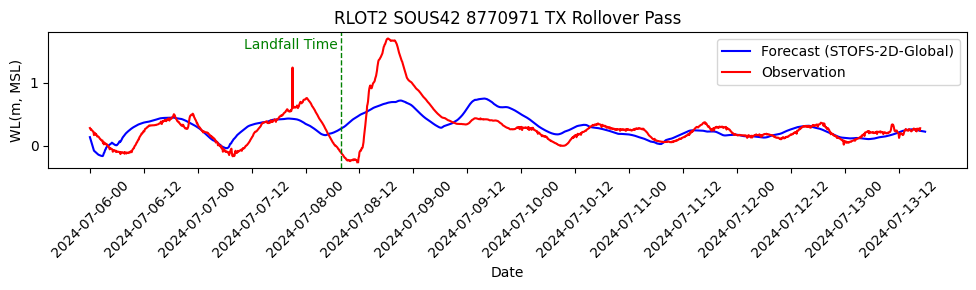

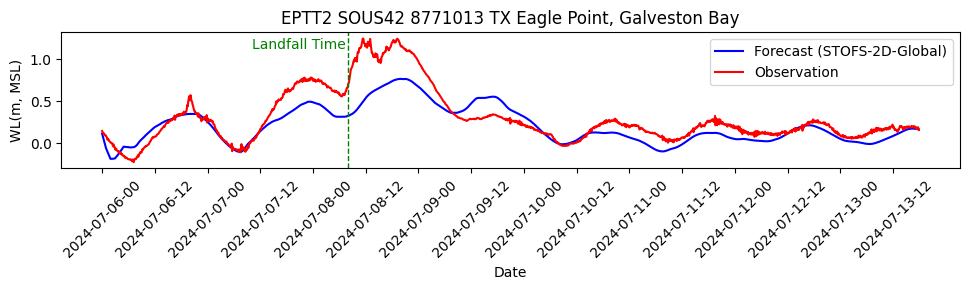

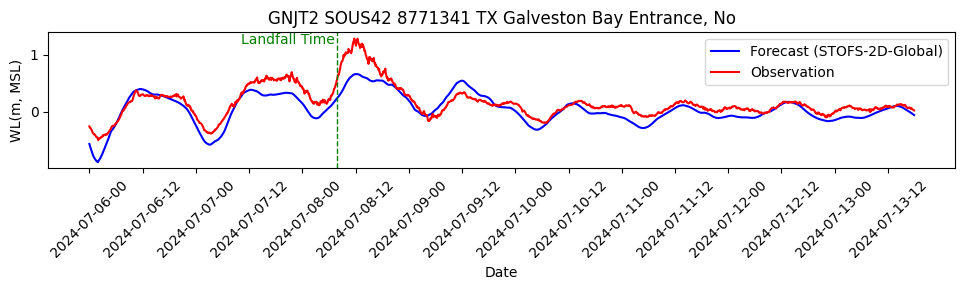

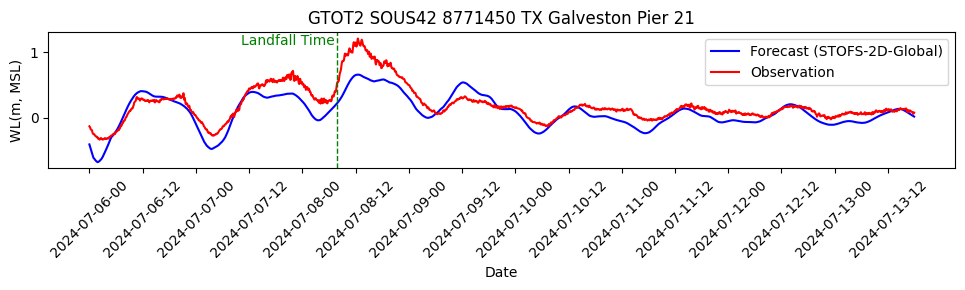

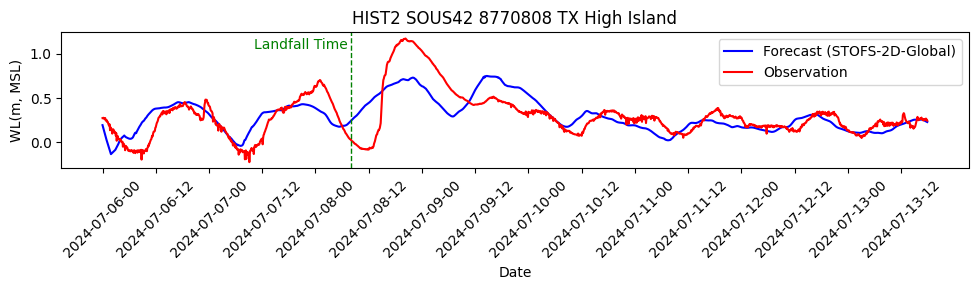

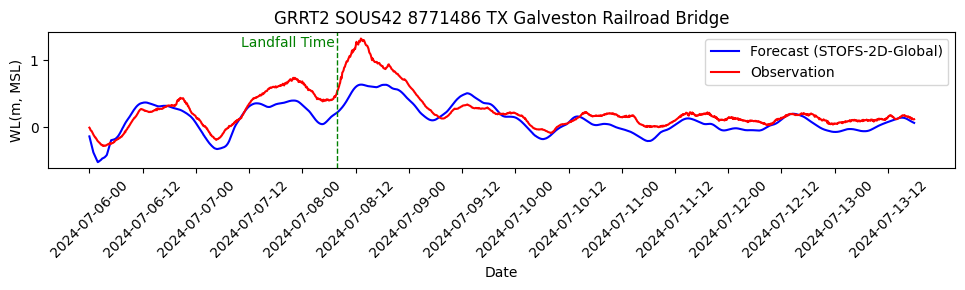

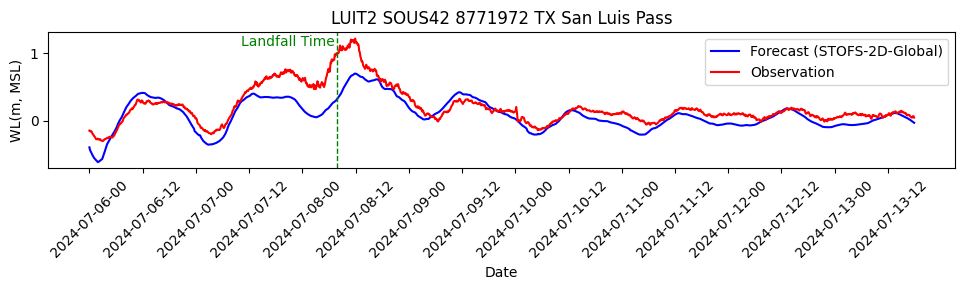

In [46]:
def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_2d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)  
    return start_date + int(time_step) * time_delta



index = 0

for nos_id in nos_id_points:
    fig, ax = plt.subplots(figsize=(10, 3))
       
    ax.plot(forecast_all_zeta_values[index,:], label='Forecast (STOFS-2D-Global)', color='blue')
    ax.plot(Observation_2d_forecast[index][0], label='Observation', color='red')


    ax.set_title(names[index])
        
    ax.set_xlabel('Date')

   
    # Set x ticks and labels
    ax.set_xticks(range(0, len(forecast_all_zeta_values[index, :]), 120)) 
    time_steps = range(0, len(forecast_all_zeta_values[index, :]))
    time_labels = [convert_to_datetime(step) for step in time_steps]
    selected_dates = time_labels[::120]
    ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)


    # Calculate the landfall time step
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    landfall_datetime = start_date + timedelta(hours=landfall_time_step)

    forecast_landfall_time_step = None 
    
    for step, time_label in zip(time_steps, time_labels): 

        if time_label.replace(tzinfo = None) == landfall_datetime:
            forecast_landfall_time_step = step 
            break   
    ax.axvline(x=forecast_landfall_time_step, color='green', linestyle='--', linewidth=1)
    ax.text(forecast_landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
    ax.set_ylabel('WL(m, MSL)')
    ax.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()
    index = index+1

# Create a figure for STOFS-2D-Global forecast data

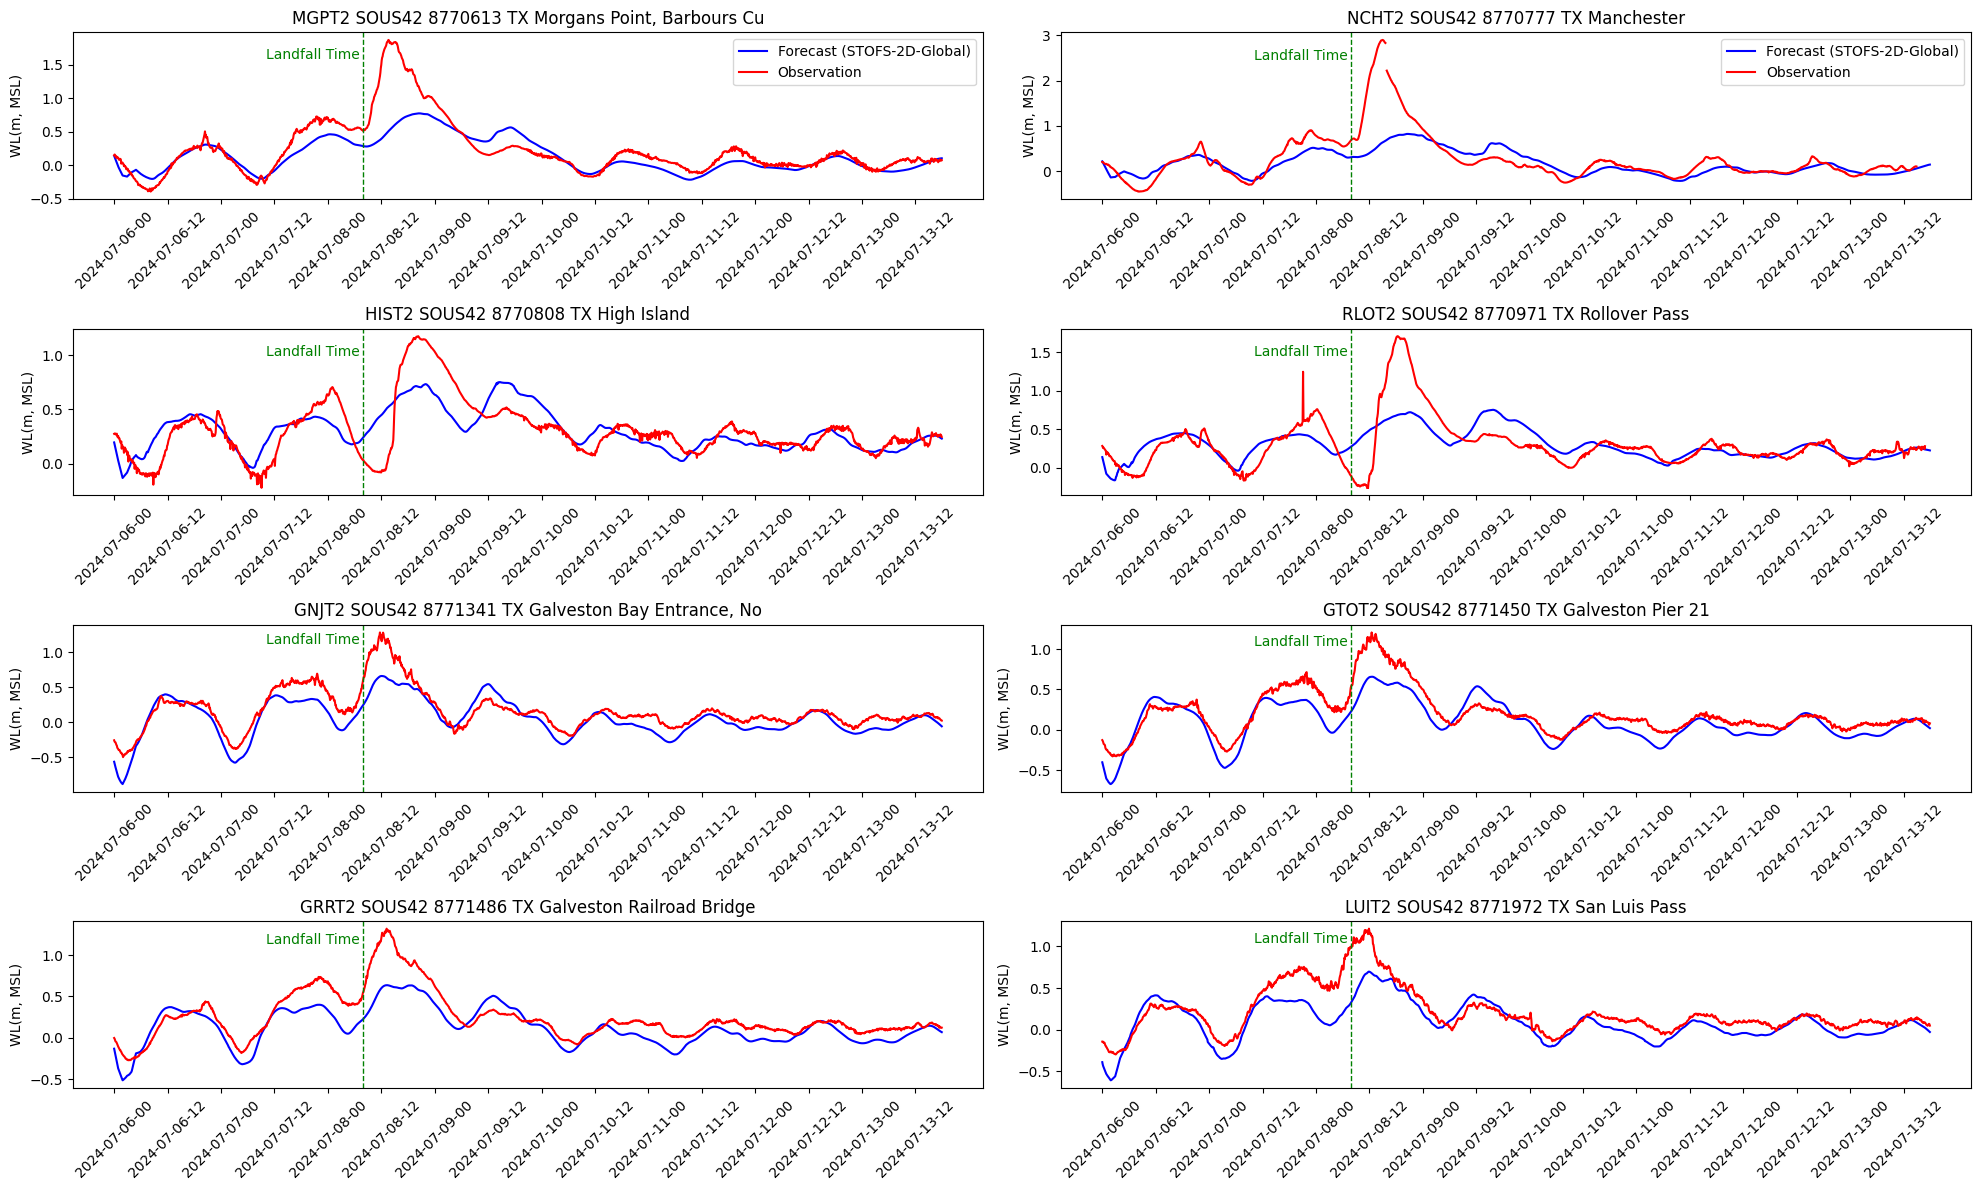

In [146]:


def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_2d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 12))  # 4 rows, 2 columns


index_3d = 0


for row in range(4):  
    for col in range(2):  
        ax = axs[row, col]
        if index_3d < len(nos_id_points_3d):

            for i in range(0,len(nos_id_points)):
                if nos_id_points[i]== nos_id_points_3d[index_3d]:
                   index_2d = i
                   break
            
            ax.plot(forecast_all_zeta_values[i, :], label='Forecast (STOFS-2D-Global)', color='blue')
            ax.plot(Observation_2d_forecast[i][0], label='Observation', color='red')
            
            ax.set_title(names[i])

            ax.set_xticks(range(0, len(forecast_all_zeta_values[index_2d, :]), 120)) 
            time_steps = range(0, len(forecast_all_zeta_values[index_2d, :]))
            time_labels = [convert_to_datetime(step) for step in time_steps]
            
            # Calculate the landfall time step
            start_date = datetime.strptime(date_range[0], '%Y%m%d')
            landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
            forecast_2d_landfall_time_step = None 
            
            for step, time_label in zip(time_steps, time_labels): 
                if time_label.replace(tzinfo = None) == landfall_datetime:
                    forecast_2d_landfall_time_step = step 
                    break   
        

            selected_dates = time_labels[::120]
            ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
            ax.axvline(x=forecast_2d_landfall_time_step, color='green', linestyle='--', linewidth=1)
            ax.text(forecast_2d_landfall_time_step*0.8, ax.get_ylim()[1]*0.8, 'Landfall Time', color='green', ha='center')
            
            ax.set_ylabel('WL(m, MSL)')
            if row == 0 :
                ax.legend(loc='upper right')
        
        index_3d += 1


plt.tight_layout()
plt.savefig(f'Forecast_2d_{Event_name}')  # Save the figure
plt.show()



# Plot Forecast for STOFS-3D-Atlantic

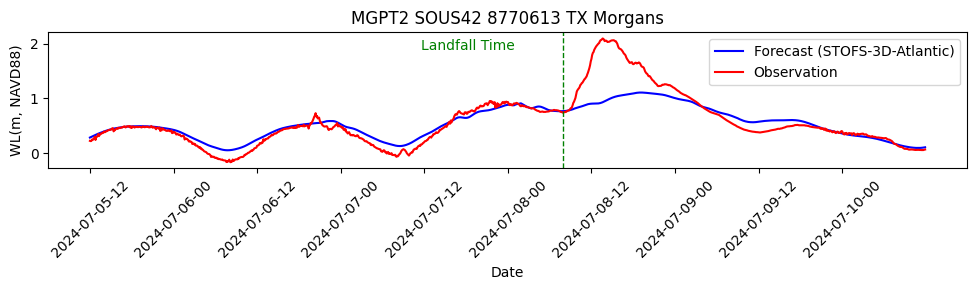

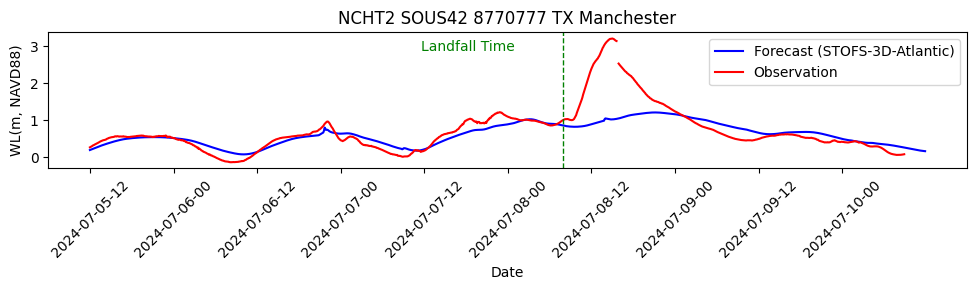

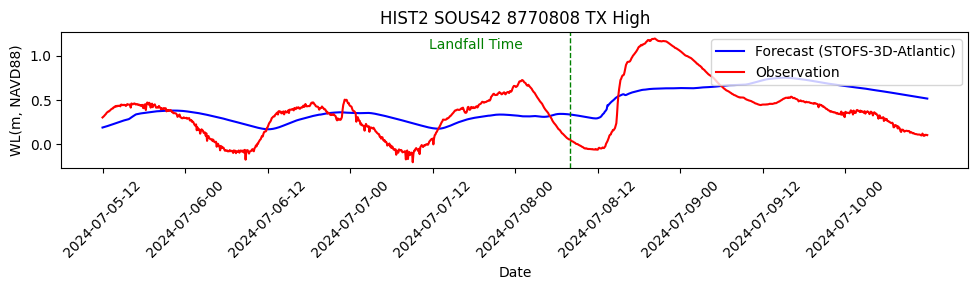

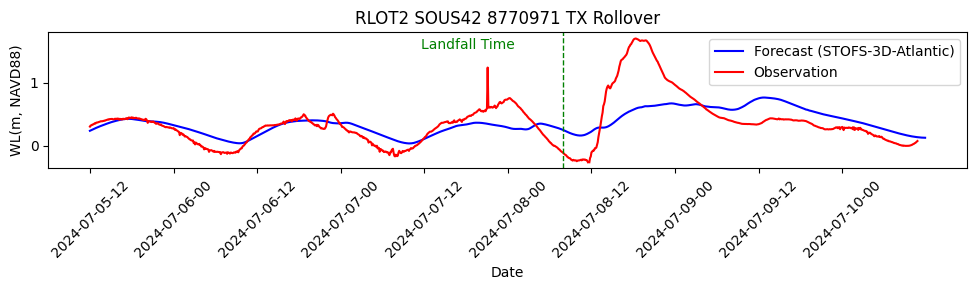

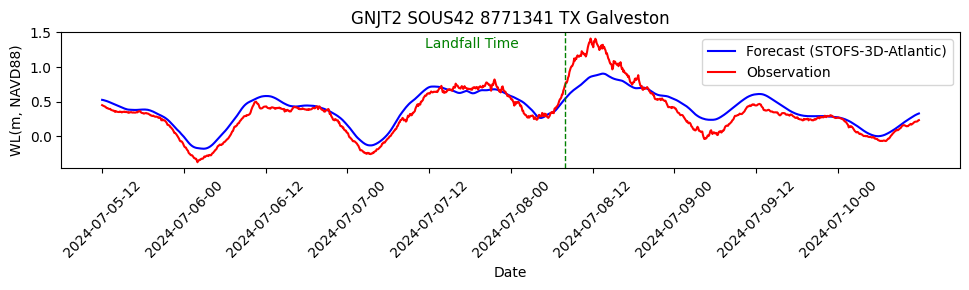

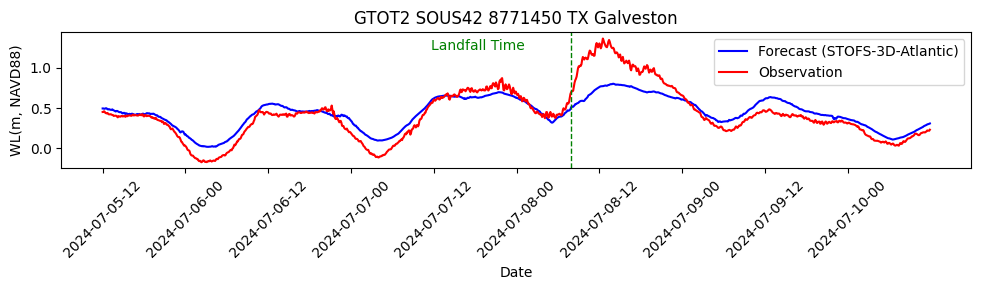

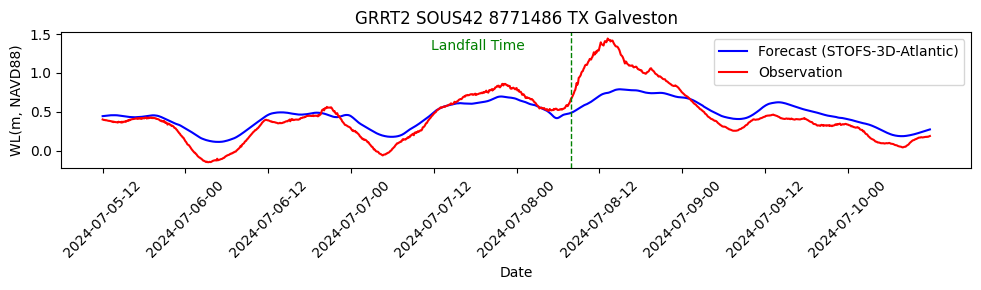

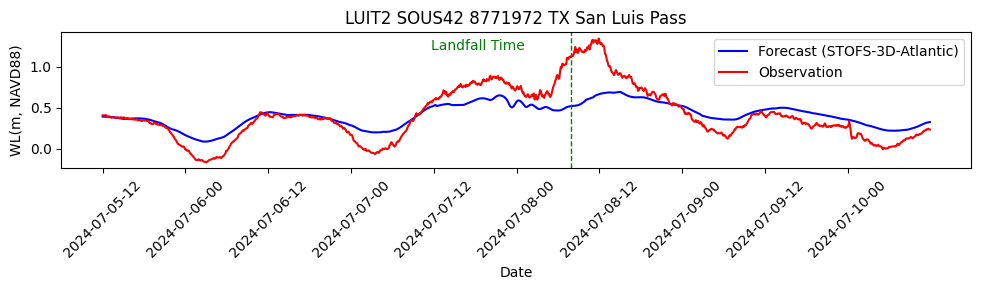

In [136]:
def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_3d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)  
    return start_date + time_step * time_delta



index = 0

for nos_id in nos_id_points_3d:
    
    fig, ax = plt.subplots(figsize=(10, 3))
       
    ax.plot(forecast_3d_all_zeta_values[index,:], label='Forecast (STOFS-3D-Atlantic)', color='blue')
    ax.plot(Observation_3d_forecast[index][0], label='Observation', color='red')


    ax.set_title(names_3d[index])
        
    ax.set_xlabel('Date')

   
    # Set x ticks and labels
    ax.set_xticks(range(0, len(forecast_3d_all_zeta_values[index, :]), 120)) 
    time_steps = range(0, len(forecast_3d_all_zeta_values[index, :]))
    time_labels = [convert_to_datetime(step) for step in time_steps]

    selected_dates = time_labels[::120]
    ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)


    # Calculate the landfall time step
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
    forecast_3d_landfall_time_step = None 
    
    for step, time_label in zip(time_steps, time_labels): 

        if time_label.replace(tzinfo = None) == landfall_datetime:
            forecast_3d_landfall_time_step = step 
            break   
            
    selected_dates = time_labels[::120]
    ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
            
    ax.axvline(x=forecast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
    ax.text(forecast_3d_landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
    ax.set_ylabel('WL(m, NAVD88)')
    ax.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()
    index = index+1

# Create a figure for STOFS-3D-Atlantic forecast data

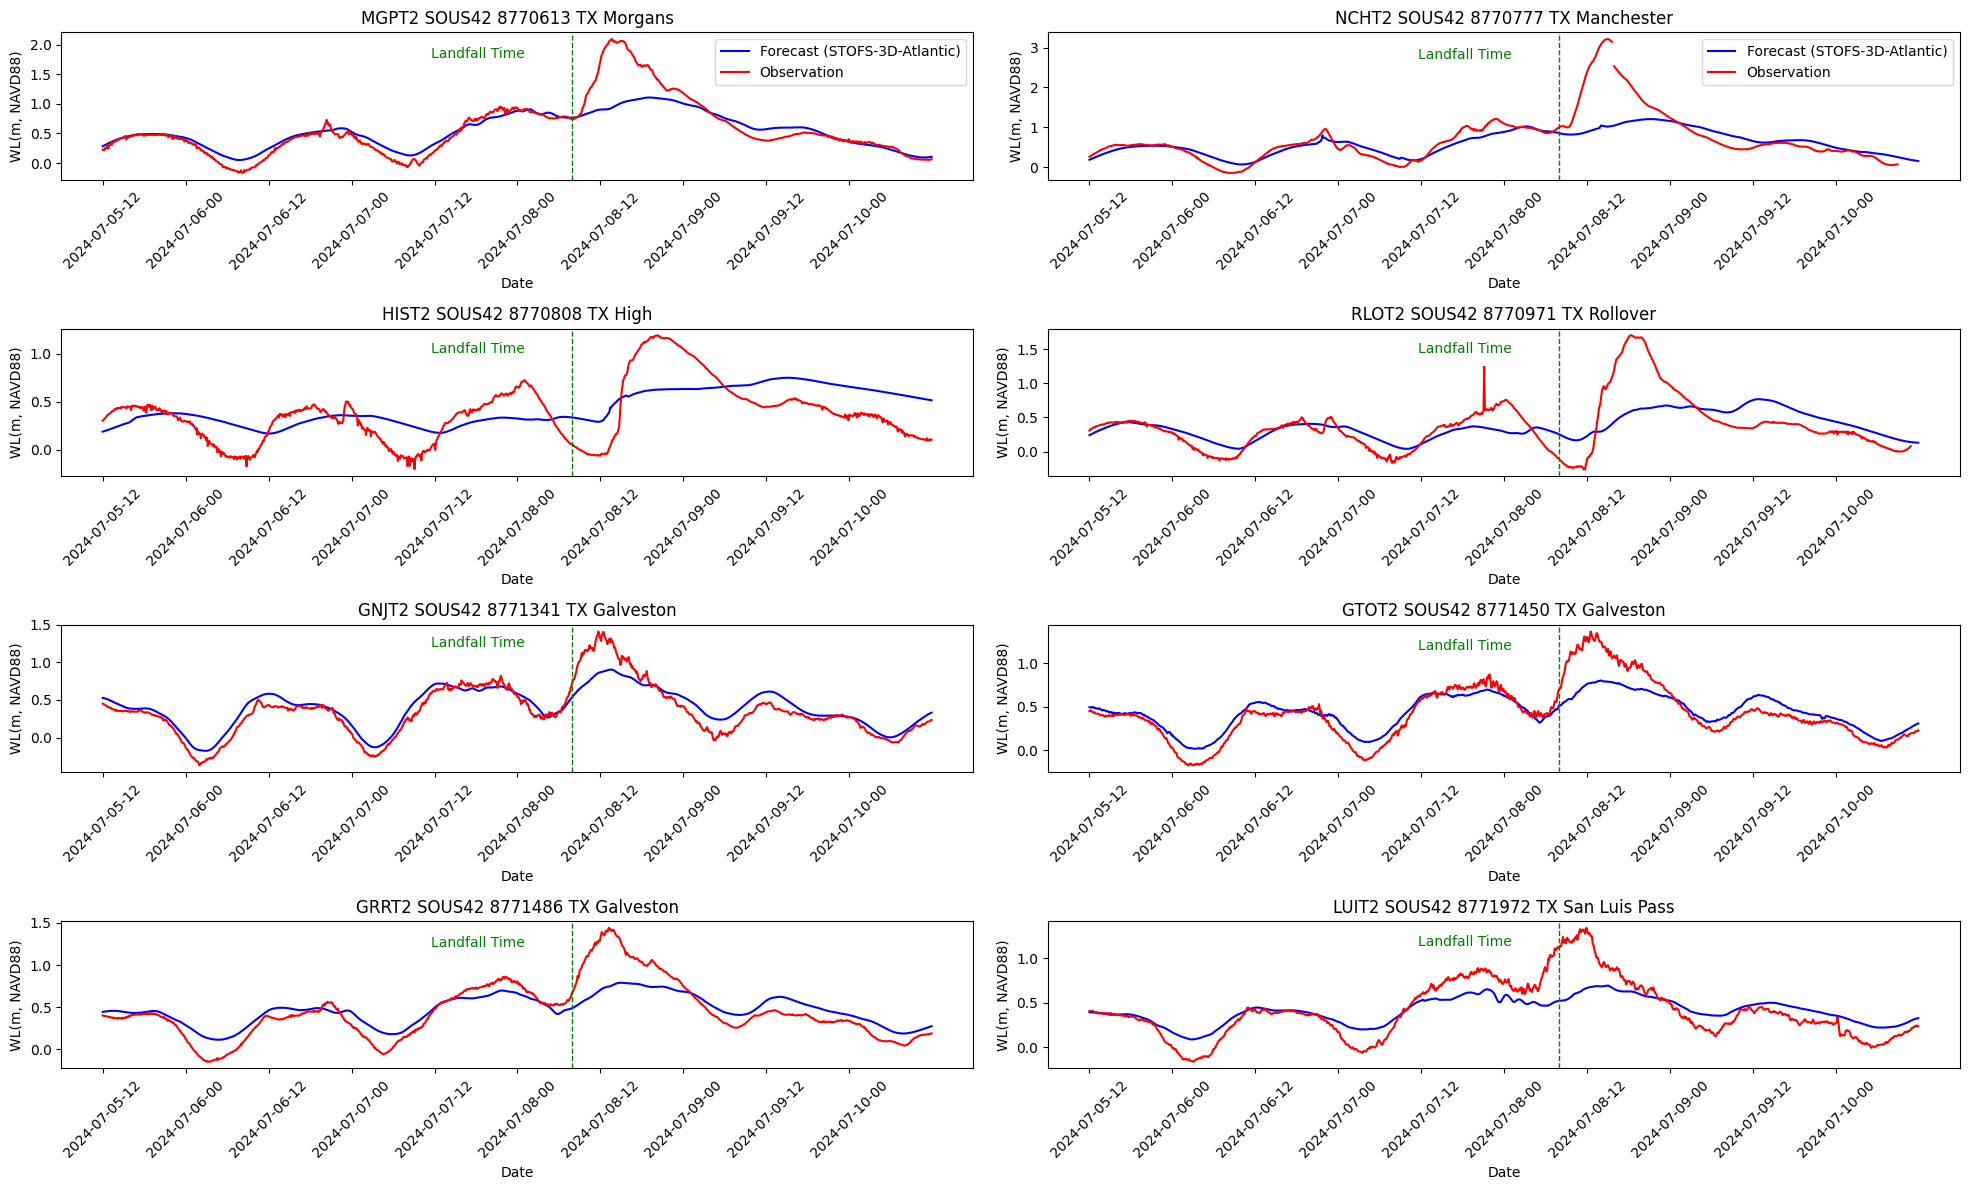

In [147]:

def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_3d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 12))  # 4 rows, 2 columns


index = 0


for row in range(4):  
    for col in range(2):  
        ax = axs[row, col]
        if index < len(nos_id_points):
            ax.plot(forecast_3d_all_zeta_values[index, :], label='Forecast (STOFS-3D-Atlantic)', color='blue')


            ax.plot(Observation_3d_forecast[index][0], label='Observation', color='red')
            
            ax.set_title(names_3d[index])
            
            ax.set_xlabel('Date')
            
            # Set x ticks and labels
            ax.set_xticks(range(0, len(forecast_3d_all_zeta_values[index, :]), 120)) 
            time_steps = range(0, len(forecast_3d_all_zeta_values[index, :]))
            time_labels = [convert_to_datetime(step) for step in time_steps]
            
            # Calculate the landfall time step
            start_date = datetime.strptime(date_range[0], '%Y%m%d')
            landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
            forecast_3d_landfall_time_step = None 
            
            for step, time_label in zip(time_steps, time_labels): 
                if time_label.replace(tzinfo = None) == landfall_datetime:
                    forecast_3d_landfall_time_step = step 
                    break   
        
            selected_dates = time_labels[::120]
            ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
   
            ax.axvline(x=forecast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
            ax.text(forecast_3d_landfall_time_step*0.8, ax.get_ylim()[1]*0.8, 'Landfall Time', color='green', ha='center')
            
            ax.set_ylabel('WL(m, NAVD88)')
            if row == 0 :
                ax.legend(loc='upper right')
        
        index += 1


plt.tight_layout()
plt.savefig(f'forecast_3d_{Event_name}')  # Save the figure
plt.show()


# Find CO-OPS wind observational stations

In [28]:
bbox = shapely.box(Region[0], Region[2], Region[1], Region[3])
all_stations = get_coops_stations(metadata_source='main', region=bbox)
wind_stations = all_stations[(all_stations.status == 'active') & (all_stations.station_type == 'met')]

wind_stations = wind_stations.sort_values(by ='nos_id')
wind_stations = wind_stations.reset_index()


wind_stations

nos_id nws_id station_type                                 name state  \
0  8770613  MGPT2          met          Morgans Point, Barbours Cut    TX   
1  8770777  NCHT2          met                           Manchester    TX   
2  8770808  HIST2          met                          High Island    TX   
3  8770971  RLOT2          met                        Rollover Pass    TX   
4  8771013  EPTT2          met           Eagle Point, Galveston Bay    TX   
5  8771341  GNJT2          met  Galveston Bay Entrance, North Jetty    TX   
6  8771450  GTOT2          met                    Galveston Pier 21    TX   
7  8771486  GRRT2          met            Galveston Railroad Bridge    TX   
8  8771972  LUIT2          met                        San Luis Pass    TX   
9  8772471  FPST2          met                      Freeport Harbor    TX   

         lon        lat removed  status                    geometry  
0 -94.985001  29.681667     NaT  active  POINT (-94.98500 29.68167)  
1 -95.265800  29.726299     NaT  active  POINT (-95.26580 29.72630)  
2 -94.390282  29.594721     NaT  active  POINT (-94.39028 29.59472)  
3 -94.513298  29.514999     NaT  active  POINT (-94.51330 29.51500)  
4 -94.917252  29.481306     NaT  active  POINT (-94.91725 29.48131)  
5 -94.724724  29.357462     NaT  active  POINT (-94.72472 29.35746)  
6 -94.793304  29.309999     NaT  active  POINT (-94.79330 29.31000)  
7 -94.897079  29.302584     NaT  active  POINT (-94.89708 29.30258)  
8 -95.130836  29.080557     NaT  active  POINT (-95.13084 29.08056)  
9 -95.294197  28.935699     NaT  active  POINT (-95.29420 28.93570)

# Read wind Observation data

In [26]:
station_id = '8770613'
station_wind = fetch_coops_station(
    station_id=station_id,
    start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc),
    end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc),
    product='wind',  interval='h'
)
station_wind

speed  degree direction  gust flags
time                                                          
2024-07-07 00:00:00+00:00    4.7   335.0       NNW   5.5   0,0
2024-07-07 01:00:00+00:00    2.9     1.0         N   3.7   0,0
2024-07-07 02:00:00+00:00    1.8    61.0       ENE   2.6   0,0
2024-07-07 03:00:00+00:00    3.0   341.0       NNW   3.8   0,0
2024-07-07 04:00:00+00:00    3.2   353.0         N   3.9   0,0
...                          ...     ...       ...   ...   ...
2024-07-09 20:00:00+00:00    3.9   299.0       WNW   4.3   0,0
2024-07-09 21:00:00+00:00    4.0    79.0         E   5.1   0,0
2024-07-09 22:00:00+00:00    3.1   113.0       ESE   3.7   0,0
2024-07-09 23:00:00+00:00    3.8   109.0       ESE   4.6   0,0
2024-07-10 00:00:00+00:00    3.9   114.0       ESE   4.5   0,0

[73 rows x 5 columns]

# Read GFS Nowcast on the Fly

In [27]:

# Initialize empty DataFrames to store wind and pressure data
u_wind_dfs = pd.DataFrame()
v_wind_dfs = pd.DataFrame()
surface_pressure_dfs = pd.DataFrame()


# Initialize list to store all time information 
all_times = []



# Loop over different files for different dates and hours
dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  
    current_date += timedelta(days=1)


for date in dates:
    print(date)
    for i, cycle in enumerate(cycles_2d): 

        print(cycle)
        for hour in range(0, 6, 1):  # Assuming we want to loop from 0 to 120 hours
            print(hour)
      
            if cycle == '00':
                current_date = datetime.strptime(date, '%Y%m%d') 
                current_date -= timedelta(days=1) # Go back one day 
                date_one_day_back = current_date.strftime('%Y%m%d')
                one_cycle_back = '18'

                # Define the filename and the location of the GRIB2 file
                key = f'gfs.{date_one_day_back}/{one_cycle_back}/atmos/gfs.t{one_cycle_back}z.sfluxgrbf{hour:03d}.grib2'
                url = f"s3://noaa-gfs-bdp-pds/{key}"
                time = datetime.strptime(date_one_day_back, '%Y%m%d') + timedelta(hours=int(one_cycle_back)) + timedelta(hours=hour) 

            else:
                previous_cycle = cycles_2d[i - 1] 
                cycle = previous_cycle 

                # Define the filename and the location of the GRIB2 file
                key = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour:03d}.grib2'
                url = f"s3://noaa-gfs-bdp-pds/{key}"
                time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(cycle)) + timedelta(hours=hour) 

            

            # Fetch the GRIB2 data from S3
            s3 = s3fs.S3FileSystem(anon=True)
            with s3.open(url, 'rb') as f:
                 grib_data = f.read()


            # Define the variable names of interest
            variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']


            # Initialize empty arrays to store data
            data_arrays = {var_name: [] for var_name in variable_names}


            # Save the GRIB2 data to a temporary file
            with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
                 tmp_file.write(grib_data)
                 tmp_file.seek(0)  # Reset file pointer to the beginning
                 # Read the GRIB2 data using pygrib from the temporary file
                 grbs = pygrib.open(tmp_file.name)


            # Iterate over each message in the GRIB2 file
            for grb in grbs:
                 # Check if the message corresponds to one of the variables of interest
                 
                 if grb['name'] in variable_names:
                    # Append data to the corresponding array
                    data_arrays[grb['name']].append(grb.values)


            # Close the GRIB2 file
            grbs.close()

            # Convert data arrays to xarray DataArrays
            pressure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
            u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
            v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')


            # Create an xarray Dataset
            ds = xr.Dataset(
            data_vars={
            'surface_pressure': pressure_data,
            'u_wind': u_wind_data,
            'v_wind': v_wind_data},
             coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,},
             attrs={
            'description': 'GRIB Data Example'})


            # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
            ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
            # Initialize empty DataFrames to store wind and pressure data for this hour
            u_wind_df = pd.DataFrame()
            v_wind_df = pd.DataFrame()
            surface_pressure_df = pd.DataFrame()
    
            # Loop over the elements of station_ds['y'] and station_ds['x']
            for y_val, x_val, nos_id in zip(wind_stations['lat'], wind_stations['lon'], wind_stations['nos_id']):
                 # Adjust target_longitude to be in the range of 0 to 360
                 longitude_adjusted = float(x_val) + 360 if float(x_val) < 0 else float(x_val)


                 # Find the index of the nearest latitude and longitude in the dataset
                 lat_idx = np.where((np.abs(ds['latitude'][0:4718592:3072] - float(y_val))) == np.min(np.abs(ds['latitude'][0:4718592:3072] - float(y_val))))
                 lon_idx = np.where((np.abs(ds['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds['longitude'][0:3072] - longitude_adjusted)))
                 

                 # Extract the forcing data using the index
                 u_wind_value = ds.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
                 v_wind_value = ds.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
                 surface_pressure_value = ds.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values


                 # Append the values to the respective DataFrames as columns with NOS ids as column names
                 u_wind_df[int(nos_id)] = [np.round(u_wind_value, 2)]
                 v_wind_df[int(nos_id)]= [np.round(v_wind_value, 2)]
                 surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value, 2)]


            u_wind_dfs = pd.concat([u_wind_dfs, u_wind_df], ignore_index=True)
            v_wind_dfs = pd.concat([v_wind_dfs, v_wind_df], ignore_index=True)
            surface_pressure_dfs = pd.concat([surface_pressure_dfs, surface_pressure_df], ignore_index=True)
            
            # Store the time information 
            all_times.append(time) 
            
            
            
# Convert all_times list to DataFrame 
time_df = pd.DataFrame({'Time': all_times}) # Print or use time_df as needed print(time_df)

time_df


20240707
00
0
1
2
3
4
5
06
0
1
2
3
4
5
12
0
1
2
3
5
18
0
1
2
3
4
5
20240708
00
0
1
2
3
4
5
06
0
1
2
3
4
5
12
0
1
2
3
4
5
18
0
1
2
3
4
5
20240709
00
0
1
2
3
4
5
06
0
1
2
3
4
5
12
0
1
2
3
4
5
18
0
1
2
3
4
5
20240710
00
0
1
2
3
4
5
06
0
1
2
3
4
5
12
0
1
2
3
4
5
18
0
1
2
3
4
5


Time
0  2024-07-06 18:00:00
1  2024-07-06 19:00:00
2  2024-07-06 20:00:00
3  2024-07-06 21:00:00
4  2024-07-06 22:00:00
..                 ...
91 2024-07-10 13:00:00
92 2024-07-10 14:00:00
93 2024-07-10 15:00:00
94 2024-07-10 16:00:00
95 2024-07-10 17:00:00

[96 rows x 1 columns]

# Read Observation data for GFS

In [6]:
# Initialize an empty DataFrame to store the data
Wind_Observation_2d_Nowcast= []

# Loop over each nos_id
for nos_id in wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=time_df['Time'][0],
       end_date=time_df['Time'][len(time_df)-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_2d_Nowcast.append(station_wind['speed'])
Wind_Observation_2d_Nowcast

NameError: name 'wind_stations' is not defined

# Plot Nowcast wind 

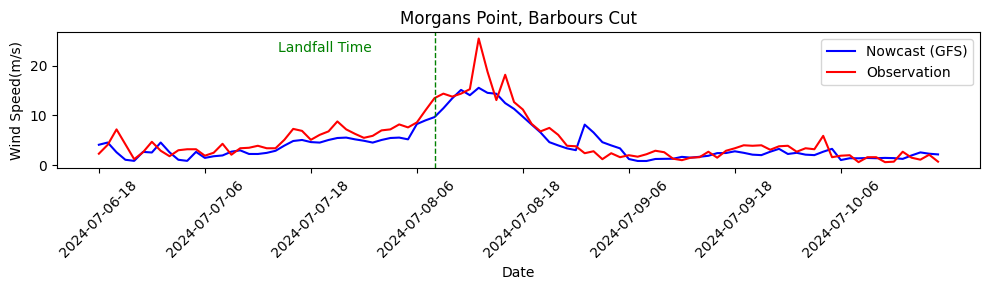

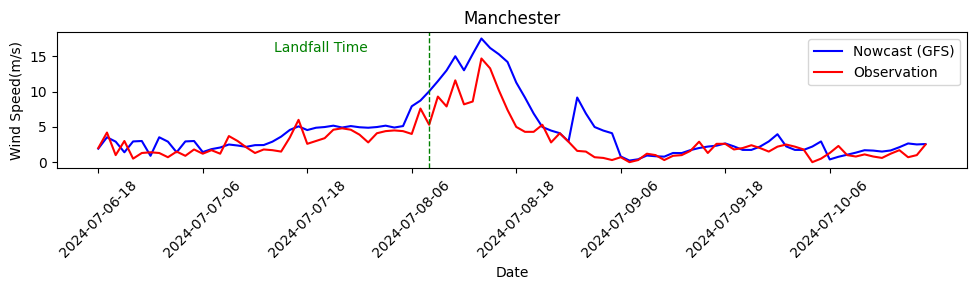

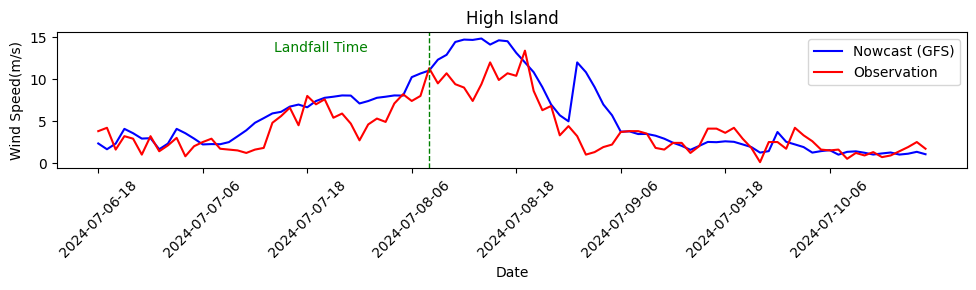

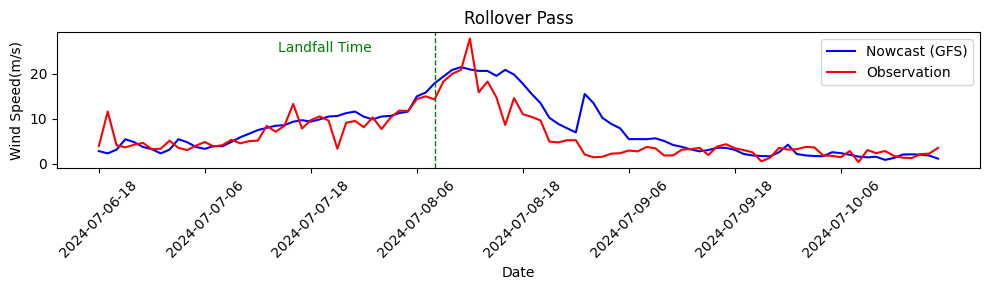

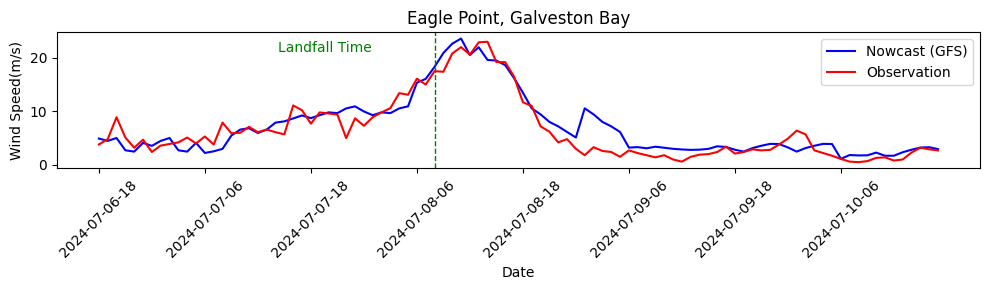

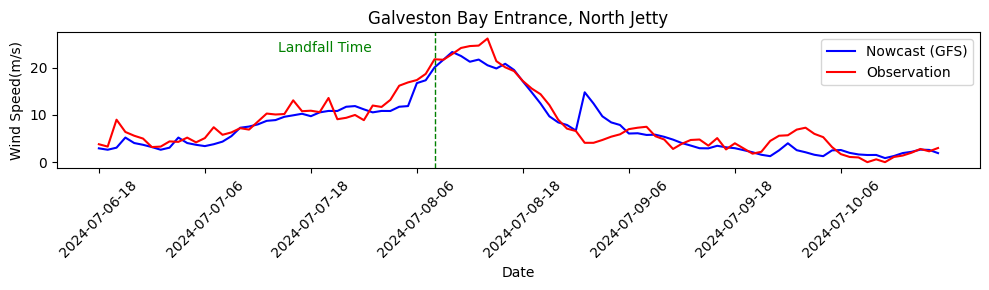

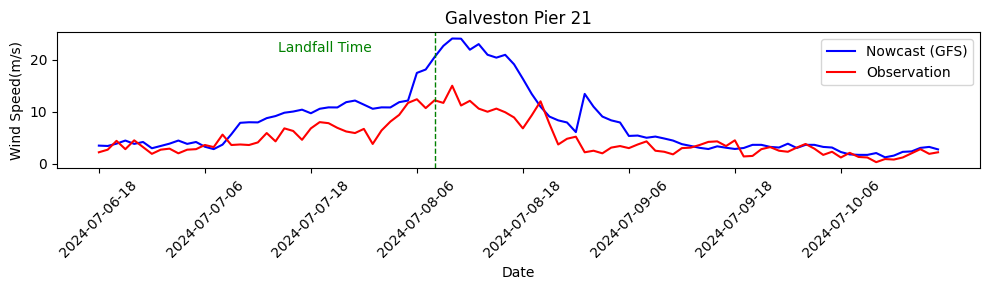

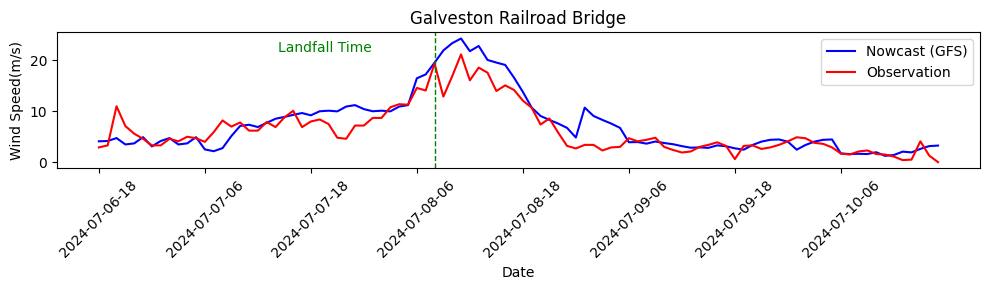

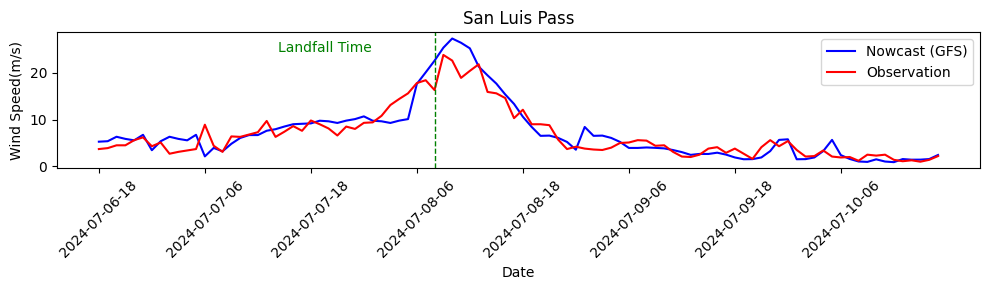

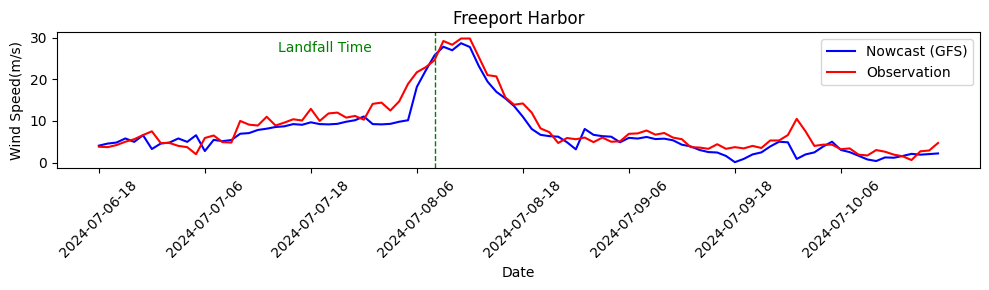

In [29]:
def convert_to_datetime(time_step):
    start_date = time_df['Time'][0]
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


index = 0

for nos_id in wind_stations['nos_id']:
    
    fig, ax = plt.subplots(figsize=(10, 3))
       
    ax.plot(np.sqrt(v_wind_dfs[int(nos_id)]**2 + u_wind_dfs[int(nos_id)]**2)[:len(Wind_Observation_2d_Nowcast[0])], label='Nowcast (GFS)', color='blue')
    ax.plot(Wind_Observation_2d_Nowcast[index].values, label='Observation', color='red')


    ax.set_title(wind_stations['name'][index])
        
    ax.set_xlabel('Date')

   
    # Set x ticks and labels
    ax.set_xticks(range(0, len(Wind_Observation_2d_Nowcast[0]), 12)) 
    time_steps = range(0, len(Wind_Observation_2d_Nowcast[0]))
    time_labels = [convert_to_datetime(step) for step in time_steps]

    selected_dates = time_labels[::12]
    ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)

    ax.axvline(x=landfall_time_step+6, color='green', linestyle='--', linewidth=1) # Add 6 because of 
    ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
    ax.set_ylabel('Wind Speed(m/s)')
    ax.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()
    index = index+1

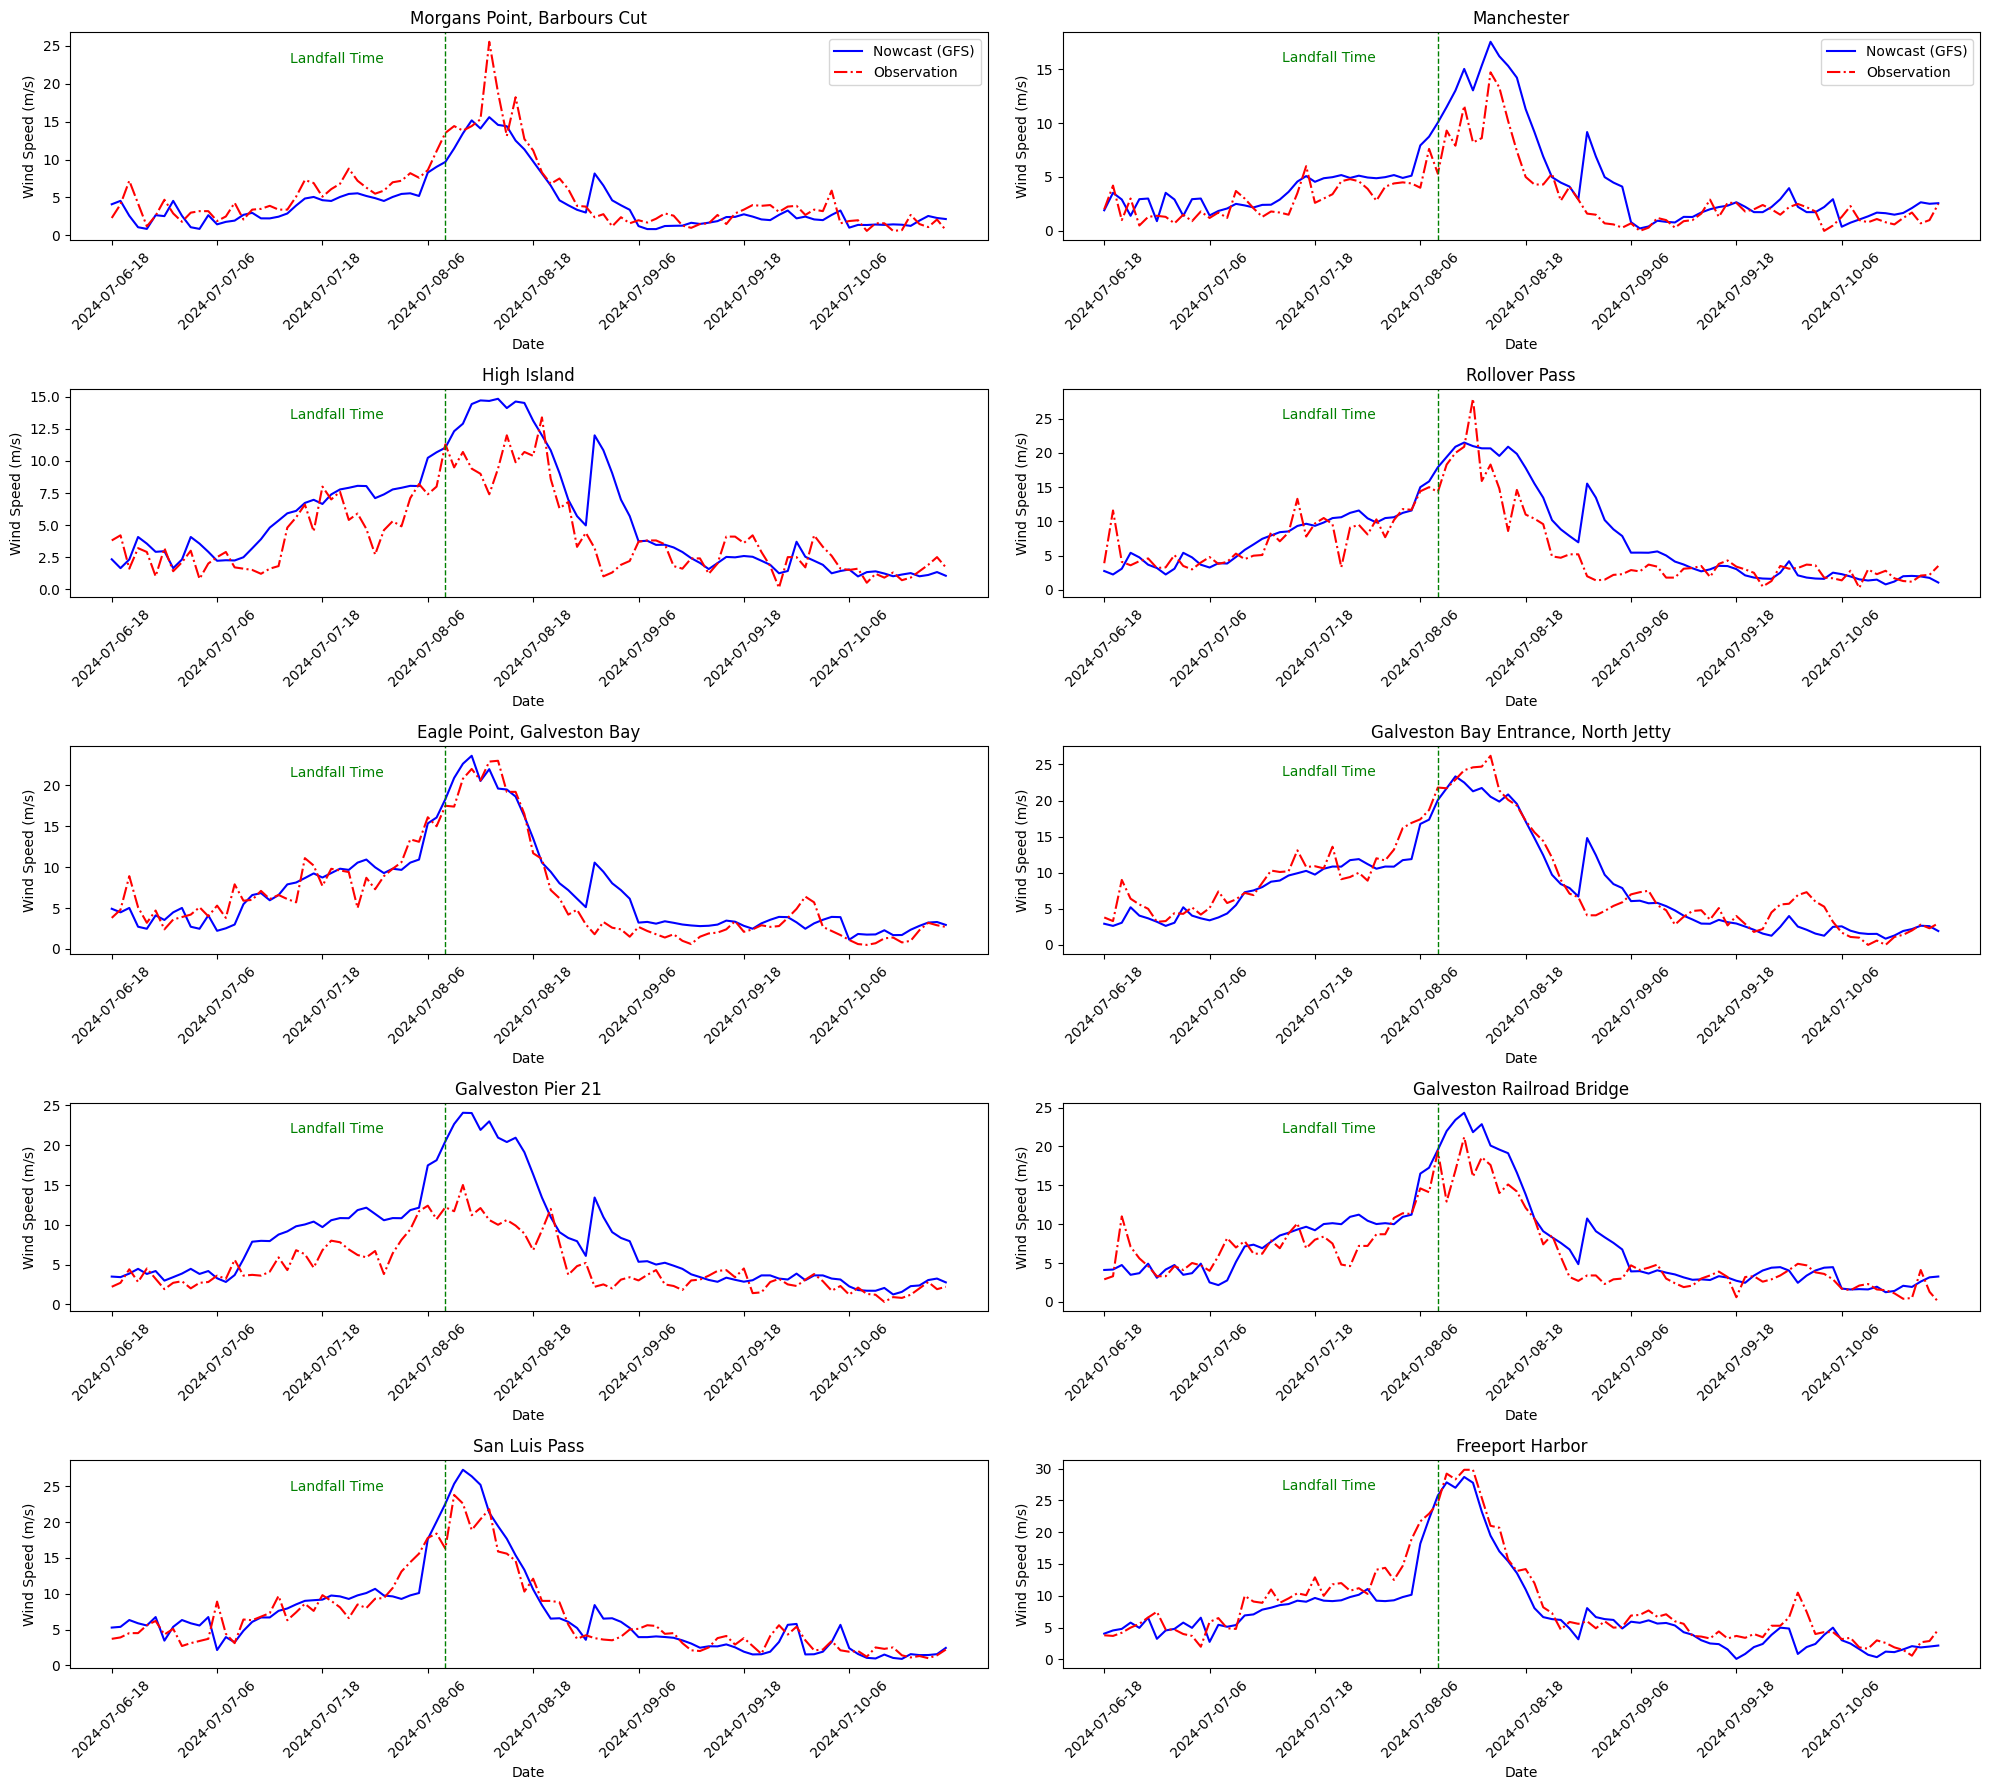

In [30]:

def convert_to_datetime(time_step):
    start_date = time_df['Time'][0]
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 2


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 18))


index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(wind_stations['nos_id']):
            break
        
        nos_id = wind_stations['nos_id'][index]
        ax = axs[row, col]
        
        ax.plot(np.sqrt(v_wind_dfs[int(nos_id)]**2 + u_wind_dfs[int(nos_id)]**2)[:len(Wind_Observation_2d_Nowcast[0])], label='Nowcast (GFS)', color='blue')
        ax.plot(Wind_Observation_2d_Nowcast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(wind_stations['name'][index])
        ax.set_xlabel('Date')
        
        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_2d_Nowcast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_2d_Nowcast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
        ax.axvline(x=landfall_time_step+6, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('GFS_Wind_nowcast.png')


# Display the plot
plt.show()






# Read GFS forecast data on the fly

In [4]:

start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage


# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')

# Find the Forecast cycle
date_H = int((start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%H'))

cycle = None
for num in cycles_2d:
    if int(num) < date_H:
        if cycle is None or int(num) > cycle:
            cycle = int(num)
cycle = f'{cycle:02}'



# Initialize empty DataFrames to store wind and pressure data
u_wind_dfs_forecast = pd.DataFrame()
v_wind_dfs_forecast = pd.DataFrame()
surface_pressure_dfs_forecast = pd.DataFrame()


# Initialize list to store all time information 
all_times = []



# Loop over different files for different dates and hours



for hour in range(0, 121, 1):  # Assuming we want to loop from 0 to 120 hours
            print(hour)
            if hour < 6:
                 if cycle == '00':
                        current_date = datetime.strptime(date, '%Y%m%d') 
                        current_date -= timedelta(days=1) # Go back one day 
                        date_one_day_back = current_date.strftime('%Y%m%d')
                        one_cycle_back = '18'

                        # Define the filename and the location of the GRIB2 file
                        key = f'gfs.{date_one_day_back}/{one_cycle_back}/atmos/gfs.t{one_cycle_back}z.sfluxgrbf{hour:03d}.grib2'
                        url = f"s3://noaa-gfs-bdp-pds/{key}"
                        time = datetime.strptime(date_one_day_back, '%Y%m%d') + timedelta(hours=int(one_cycle_back)) + timedelta(hours=hour) 

                 else:
                        
                        
                        previous_cycle = cycles_2d[cycles_2d.index('06') - 1] 
                         
                        # Define the filename and the location of the GRIB2 file
                        key = f'gfs.{date}/{previous_cycle}/atmos/gfs.t{previous_cycle}z.sfluxgrbf{hour:03d}.grib2'
                        url = f"s3://noaa-gfs-bdp-pds/{key}"
                        time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(previous_cycle)) + timedelta(hours=hour) 

            else: 
                
                # Define the filename and the location of the GRIB2 file
                key = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour:03d}.grib2'
                url = f"s3://noaa-gfs-bdp-pds/{key}"
                time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(cycle)) + timedelta(hours=hour) 

                

            # Fetch the GRIB2 data from S3
            s3 = s3fs.S3FileSystem(anon=True)
            with s3.open(url, 'rb') as f:
                 grib_data = f.read()


            # Define the variable names of interest
            variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']


            # Initialize empty arrays to store data
            data_arrays = {var_name: [] for var_name in variable_names}


            # Save the GRIB2 data to a temporary file
            with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
                 tmp_file.write(grib_data)
                 tmp_file.seek(0)  # Reset file pointer to the beginning
                 # Read the GRIB2 data using pygrib from the temporary file
                 grbs = pygrib.open(tmp_file.name)


            # Iterate over each message in the GRIB2 file
            for grb in grbs:
                 # Check if the message corresponds to one of the variables of interest
                 
                 if grb['name'] in variable_names:
                    # Append data to the corresponding array
                    data_arrays[grb['name']].append(grb.values)


            # Close the GRIB2 file
            grbs.close()

            # Convert data arrays to xarray DataArrays
            pressure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
            u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
            v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')


            # Create an xarray Dataset
            ds = xr.Dataset(
            data_vars={
            'surface_pressure': pressure_data,
            'u_wind': u_wind_data,
            'v_wind': v_wind_data},
             coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,},
             attrs={
            'description': 'GRIB Data Example'})


            # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
            ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
            # Initialize empty DataFrames to store wind and pressure data for this hour
            u_wind_df_f = pd.DataFrame()
            v_wind_df_f = pd.DataFrame()
            surface_pressure_df_f = pd.DataFrame()
    
            # Loop over the elements of station_ds['y'] and station_ds['x']
            for y_val, x_val, nos_id in zip(wind_stations['lat'], wind_stations['lon'], wind_stations['nos_id']):
                 # Adjust target_longitude to be in the range of 0 to 360
                 longitude_adjusted = float(x_val) + 360 if float(x_val) < 0 else float(x_val)


                 # Find the index of the nearest latitude and longitude in the dataset
                 lat_idx = np.where((np.abs(ds['latitude'][0:4718592:3072] - float(y_val))) == np.min(np.abs(ds['latitude'][0:4718592:3072] - float(y_val))))
                 lon_idx = np.where((np.abs(ds['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds['longitude'][0:3072] - longitude_adjusted)))
                 

                 # Extract the forcing data using the index
                 u_wind_value = ds.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
                 v_wind_value = ds.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
                 surface_pressure_value = ds.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values


                 # Append the values to the respective DataFrames as columns with NOS ids as column names
                 u_wind_df_f[int(nos_id)] = [np.round(u_wind_value, 2)]
                 v_wind_df_f[int(nos_id)]= [np.round(v_wind_value, 2)]
                 surface_pressure_df_f[int(nos_id)] = [np.round(surface_pressure_value, 2)]


            u_wind_dfs_forecast = pd.concat([u_wind_dfs_forecast, u_wind_df_f], ignore_index=True)
            print(u_wind_dfs_forecast)
            v_wind_dfs_forecast = pd.concat([v_wind_dfs_forecast, v_wind_df_f], ignore_index=True)
            surface_pressure_dfs_forecast = pd.concat([surface_pressure_dfs_forecast, surface_pressure_df_f], ignore_index=True)
            
            # Store the time information 
            all_times.append(time) 
            
   



0


KeyboardInterrupt: 

In [32]:
 u_wind_dfs_forecast

8770613  8770777  8770808  8770971  8771013  8771341  8771450  8771486  \
0      -2.67    -2.42     0.37     0.55     0.60     0.95     1.16     0.92   
1      -0.98    -1.68     1.09     1.56     1.34     1.53     1.57     1.36   
2       0.30    -0.65     0.89     1.23     1.09     1.13     1.12     0.92   
3       0.48     0.13     0.51     1.05     0.89     0.80     0.81     0.77   
4       0.60     1.09     0.40     1.01     0.91     0.74     0.76     0.80   
..       ...      ...      ...      ...      ...      ...      ...      ...   
116     1.34     1.19     2.29     4.47     2.95     4.64     4.73     3.85   
117     1.26     1.16     3.06     5.33     2.44     5.23     4.87     3.55   
118     1.05     0.89     3.46     5.41     2.32     5.18     4.38     3.06   
119     0.69     0.47     3.80     5.07     2.31     4.70     3.71     2.53   
120     0.51     0.60     3.67     4.14     2.33     4.03     2.99     2.20   

     8771972  8772471  
0      -0.32    -0.07  
1      -0.08    -0.13  
2       0.33    -0.33  
3       0.68    -0.09  
4       0.74     0.31  
..       ...      ...  
116     3.03     1.73  
117     2.89     1.98  
118     2.75     2.35  
119     2.45     2.70  
120     2.83     3.17  

[121 rows x 10 columns]

In [33]:
v_wind_dfs_forecast

8770613  8770777  8770808  8770971  8771013  8771341  8771450  8771486  \
0       2.65     4.70     3.10     4.67     5.14     4.92     5.20     5.10   
1       3.24     4.56     2.80     4.35     5.13     4.77     5.07     4.78   
2       3.39     3.89     2.89     4.65     4.65     4.94     5.17     4.57   
3       3.21     3.67     2.93     4.68     4.04     4.76     4.78     4.11   
4       2.76     3.42     2.62     4.18     3.69     4.53     4.55     3.91   
..       ...      ...      ...      ...      ...      ...      ...      ...   
116    -0.71    -0.90     3.80     6.41     0.89     6.15     4.97     2.68   
117    -0.35    -0.93     3.60     5.55     0.18     4.76     3.21     1.31   
118    -0.49    -0.90     3.36     3.94     0.54     3.31     1.86     0.75   
119    -0.64    -0.74     2.50     2.08     1.02     2.18     1.18     0.66   
120    -0.60    -0.43     1.33     1.35     1.34     2.20     1.51     0.95   

     8771972  8772471  
0       4.70     4.29  
1       4.01     3.93  
2       4.06     3.90  
3       3.66     4.06  
4       3.46     4.27  
..       ...      ...  
116     3.17     5.15  
117     2.17     4.36  
118     1.34     4.22  
119     1.25     4.19  
120     1.45     4.32  

[121 rows x 10 columns]

# Read one GFS 3-hourly Data on the Fly 

In [34]:
# Loop over different files for different hours
for hour in range(120, 184, 3):  
    print(hour)
    # Define the filename and the location of the GRIB2 file for the current hour

    key_current = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour:03d}.grib2'
    url_current = f"s3://noaa-gfs-bdp-pds/{key_current}"
    time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(cycle)) + timedelta(hours=hour) 

    # Fetch the GRIB2 data from S3 for the current hour
    s3_current = s3fs.S3FileSystem(anon=True)
    with s3_current.open(url_current, 'rb') as f_current:
        grib_data_current = f_current.read()

    # Define the variable names of interest
    variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']

    # Initialize empty arrays to store current data
    data_arrays_current = {var_name: [] for var_name in variable_names}

    # Save the current GRIB2 data to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
        tmp_file.write(grib_data_current)
        tmp_file.seek(0)  # Reset file pointer to the beginning
        # Read the GRIB2 data using pygrib from the temporary file
        grbs = pygrib.open(tmp_file.name)

        # Iterate over each message in the GRIB2 file
        for grb in grbs:
            # Check if the message corresponds to one of the variables of interest
            if grb['name'] in variable_names:
                # Append data to the corresponding array
                data_arrays_current[grb['name']].append(grb.values)

        # Close the GRIB2 file
        grbs.close()

    
    # Convert data arrays to xarray DataArrays for current data
    pressure_data_current = xr.DataArray(np.array(data_arrays_current['Surface pressure']), name='surface_pressure')
    u_wind_data_current = xr.DataArray(np.array(data_arrays_current['10 metre U wind component']), name='u_wind')
    v_wind_data_current = xr.DataArray(np.array(data_arrays_current['10 metre V wind component']), name='v_wind')

    # Create an xarray Dataset for current data
    ds_current = xr.Dataset(
        data_vars={
            'surface_pressure': pressure_data_current,
            'u_wind': u_wind_data_current,
            'v_wind': v_wind_data_current,
        },
        coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
        },
        attrs={
            'description': 'GRIB Data Example',
        },
    )

    # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
    ds_current = ds_current.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
    # Define the filename and the location of the GRIB2 file for the next hour
    hour_next = hour + 3  # Assuming data is available 3-hourly
    key_next = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour_next:03d}.grib2'
    url_next = f"s3://noaa-gfs-bdp-pds/{key_next}"
  
    # Fetch the GRIB2 data from S3 for the next hour
    s3_next = s3fs.S3FileSystem(anon=True)
    with s3_next.open(url_next, 'rb') as f_next:
        grib_data_next = f_next.read()

    # Initialize empty arrays to store current data
    data_arrays_next = {var_name: [] for var_name in variable_names}

    # Save the current GRIB2 data to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
        tmp_file.write(grib_data_next)
        tmp_file.seek(0)  # Reset file pointer to the beginning
        # Read the GRIB2 data using pygrib from the temporary file
        grbs = pygrib.open(tmp_file.name)

        # Iterate over each message in the GRIB2 file
        for grb in grbs:
            # Check if the message corresponds to one of the variables of interest
            if grb['name'] in variable_names:
                # Append data to the corresponding array
                data_arrays_next[grb['name']].append(grb.values)

        # Close the GRIB2 file
        grbs.close()


    # Convert data arrays to xarray DataArrays for next file data
    pressure_data_next = xr.DataArray(np.array(data_arrays_next['Surface pressure']), name='surface_pressure')
    u_wind_data_next = xr.DataArray(np.array(data_arrays_next['10 metre U wind component']), name='u_wind')
    v_wind_data_next = xr.DataArray(np.array(data_arrays_next['10 metre V wind component']), name='v_wind')

    # Create an xarray Dataset for next file data
    ds_next = xr.Dataset(
        data_vars={
            'surface_pressure': pressure_data_next,
            'u_wind': u_wind_data_next,
            'v_wind': v_wind_data_next,
        },
        coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
        },
        attrs={
            'description': 'GRIB Data Example',
        },
    )

    # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
    ds_next = ds_next.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})

    # Initialize empty DataFrames to store wind and pressure data for this hour
    for hour_1 in range(1, 4, 1): 
        
        u_wind_df = pd.DataFrame()
        v_wind_df = pd.DataFrame()
        surface_pressure_df = pd.DataFrame()
    
        # Loop over the elements of station_ds['y'] and station_ds['x']
        for y_val, x_val, nos_id in zip(station_ds['y'], station_ds['x'], station_ds['nos_id']):
            # Adjust target_longitude to be in the range of 0 to 360
            longitude_adjusted = int(x_val) + 360 if int(x_val) < 0 else int(x_val)

            # Find the index of the nearest latitude and longitude in the dataset
            lat_idx = np.where((np.abs(ds_current['latitude'][0:4718592:3072] - int(y_val))) == np.min(np.abs(ds_current['latitude'][0:4718592:3072] - int(y_val))))
            lon_idx = np.where((np.abs(ds_current['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds_current['longitude'][0:3072] - longitude_adjusted)))

            # Extract the current forcing data using the index 
            u_wind_value_0 = ds_current.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            v_wind_value_0 = ds_current.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            surface_pressure_value_0 = ds_current.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values

            # Extract the next forcing data using the index 
            u_wind_value_3 = ds_next.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            v_wind_value_3 = ds_next.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            surface_pressure_value_3 = ds_next.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values
            
            # Calculate interpolation coefficient
            u_wind_coeff = (u_wind_value_3 - u_wind_value_0) / 3
            v_wind_coeff = (v_wind_value_3 - v_wind_value_0) / 3 
            surface_pressure_coeff = (surface_pressure_value_3 - surface_pressure_value_0) / 3 
                        
            # Append the values to the respective DataFrames as columns with NOS ids as column names
            u_wind_df[int(nos_id)] = [np.round(u_wind_value_0, 2)] + hour_1*u_wind_coeff
            v_wind_df[int(nos_id)]= [np.round(v_wind_value_0, 2)] + hour_1*v_wind_coeff
            surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value_0, 2)] + hour_1*surface_pressure_coeff

        u_wind_dfs_forecast = pd.concat([u_wind_dfs_forecast, u_wind_df], ignore_index=True)
        v_wind_dfs_forecast = pd.concat([v_wind_dfs_forecast, v_wind_df], ignore_index=True)
        surface_pressure_dfs_forecast = pd.concat([surface_pressure_dfs_forecast, surface_pressure_df], ignore_index=True)
        all_times.append(time) 

# Convert all_times list to DataFrame 
time_df = pd.DataFrame({'Time': all_times}) # Print or use time_df as needed print(time_df)

time_df



120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183


Time
0   2024-07-06 00:00:00
1   2024-07-06 01:00:00
2   2024-07-06 02:00:00
3   2024-07-06 03:00:00
4   2024-07-06 04:00:00
..                  ...
182 2024-07-13 18:00:00
183 2024-07-13 18:00:00
184 2024-07-13 21:00:00
185 2024-07-13 21:00:00
186 2024-07-13 21:00:00

[187 rows x 1 columns]

In [35]:
u_wind_dfs_forecast

8770613   8770777   8770808   8770971   8771013   8771341   8771450  \
0   -2.670000 -2.420000  0.370000  0.550000  0.600000  0.950000  1.160000   
1   -0.980000 -1.680000  1.090000  1.560000  1.340000  1.530000  1.570000   
2    0.300000 -0.650000  0.890000  1.230000  1.090000  1.130000  1.120000   
3    0.480000  0.130000  0.510000  1.050000  0.890000  0.800000  0.810000   
4    0.600000  1.090000  0.400000  1.010000  0.910000  0.740000  0.760000   
..        ...       ...       ...       ...       ...       ...       ...   
182 -4.023333 -3.213333 -4.023333 -4.023333 -4.023333 -4.023333 -4.023333   
183 -4.520000 -3.500000 -4.520000 -4.520000 -4.520000 -4.520000 -4.520000   
184 -4.373333 -3.540000 -4.373333 -4.373333 -4.373333 -4.373333 -4.373333   
185 -4.226667 -3.580000 -4.226667 -4.226667 -4.226667 -4.226667 -4.226667   
186 -4.080000 -3.620000 -4.080000 -4.080000 -4.080000 -4.080000 -4.080000   

      8771486   8771972   8772471  
0    0.920000 -0.320000 -0.070000  
1    1.360000 -0.080000 -0.130000  
2    0.920000  0.330000 -0.330000  
3    0.770000  0.680000 -0.090000  
4    0.800000  0.740000  0.310000  
..        ...       ...       ...  
182 -4.023333 -3.213333 -4.056667  
183 -4.520000 -3.500000 -4.440000  
184 -4.373333 -3.540000 -4.453333  
185 -4.226667 -3.580000 -4.466667  
186 -4.080000 -3.620000 -4.480000  

[187 rows x 10 columns]

In [36]:
v_wind_dfs_forecast

8770613   8770777   8770808   8770971   8771013   8771341   8771450  \
0    2.650000  4.700000  3.100000  4.670000  5.140000  4.920000  5.200000   
1    3.240000  4.560000  2.800000  4.350000  5.130000  4.770000  5.070000   
2    3.390000  3.890000  2.890000  4.650000  4.650000  4.940000  5.170000   
3    3.210000  3.670000  2.930000  4.680000  4.040000  4.760000  4.780000   
4    2.760000  3.420000  2.620000  4.180000  3.690000  4.530000  4.550000   
..        ...       ...       ...       ...       ...       ...       ...   
182  1.786667  3.163333  1.786667  1.786667  1.786667  1.786667  1.786667   
183  1.910000  3.320000  1.910000  1.910000  1.910000  1.910000  1.910000   
184  2.333333  3.216667  2.333333  2.333333  2.333333  2.333333  2.333333   
185  2.756667  3.113333  2.756667  2.756667  2.756667  2.756667  2.756667   
186  3.180000  3.010000  3.180000  3.180000  3.180000  3.180000  3.180000   

      8771486   8771972   8772471  
0    5.100000  4.700000  4.290000  
1    4.780000  4.010000  3.930000  
2    4.570000  4.060000  3.900000  
3    4.110000  3.660000  4.060000  
4    3.910000  3.460000  4.270000  
..        ...       ...       ...  
182  1.786667  3.163333  1.606667  
183  1.910000  3.320000  1.460000  
184  2.333333  3.216667  1.523333  
185  2.756667  3.113333  1.586667  
186  3.180000  3.010000  1.650000  

[187 rows x 10 columns]

In [37]:
time_df

Time
0   2024-07-06 00:00:00
1   2024-07-06 01:00:00
2   2024-07-06 02:00:00
3   2024-07-06 03:00:00
4   2024-07-06 04:00:00
..                  ...
182 2024-07-13 18:00:00
183 2024-07-13 18:00:00
184 2024-07-13 21:00:00
185 2024-07-13 21:00:00
186 2024-07-13 21:00:00

[187 rows x 1 columns]

# Get Observation Data for forecast Data

In [41]:
# Initialize an empty DataFrame to store the data
Wind_Observation_2d_forecast= []

# Loop over each nos_id
for nos_id in wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=time_df['Time'][0],
       end_date=time_df['Time'][len(time_df)-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_2d_forecast.append(station_wind['speed'])
Wind_Observation_2d_forecast

/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is ret

[time
 2024-07-06 00:00:00+00:00    4.1
 2024-07-06 01:00:00+00:00    3.8
 2024-07-06 02:00:00+00:00    4.7
 2024-07-06 03:00:00+00:00    2.4
 2024-07-06 04:00:00+00:00    3.3
                             ... 
 2024-07-13 17:00:00+00:00    1.0
 2024-07-13 18:00:00+00:00    2.3
 2024-07-13 19:00:00+00:00    2.8
 2024-07-13 20:00:00+00:00    2.3
 2024-07-13 21:00:00+00:00    3.2
 Name: speed, Length: 190, dtype: float64,
 time
 2024-07-06 00:00:00+00:00    1.9
 2024-07-06 01:00:00+00:00    3.3
 2024-07-06 02:00:00+00:00    3.9
 2024-07-06 03:00:00+00:00    3.7
 2024-07-06 04:00:00+00:00    1.6
                             ... 
 2024-07-13 17:00:00+00:00    0.7
 2024-07-13 18:00:00+00:00    1.4
 2024-07-13 19:00:00+00:00    2.6
 2024-07-13 20:00:00+00:00    2.1
 2024-07-13 21:00:00+00:00    2.1
 Name: speed, Length: 190, dtype: float64,
 time
 2024-07-06 00:00:00+00:00    4.5
 2024-07-06 01:00:00+00:00    2.9
 2024-07-06 02:00:00+00:00    1.9
 2024-07-06 03:00:00+00:00    1.6
 2024-07-06 

# Plot GFS forecast 

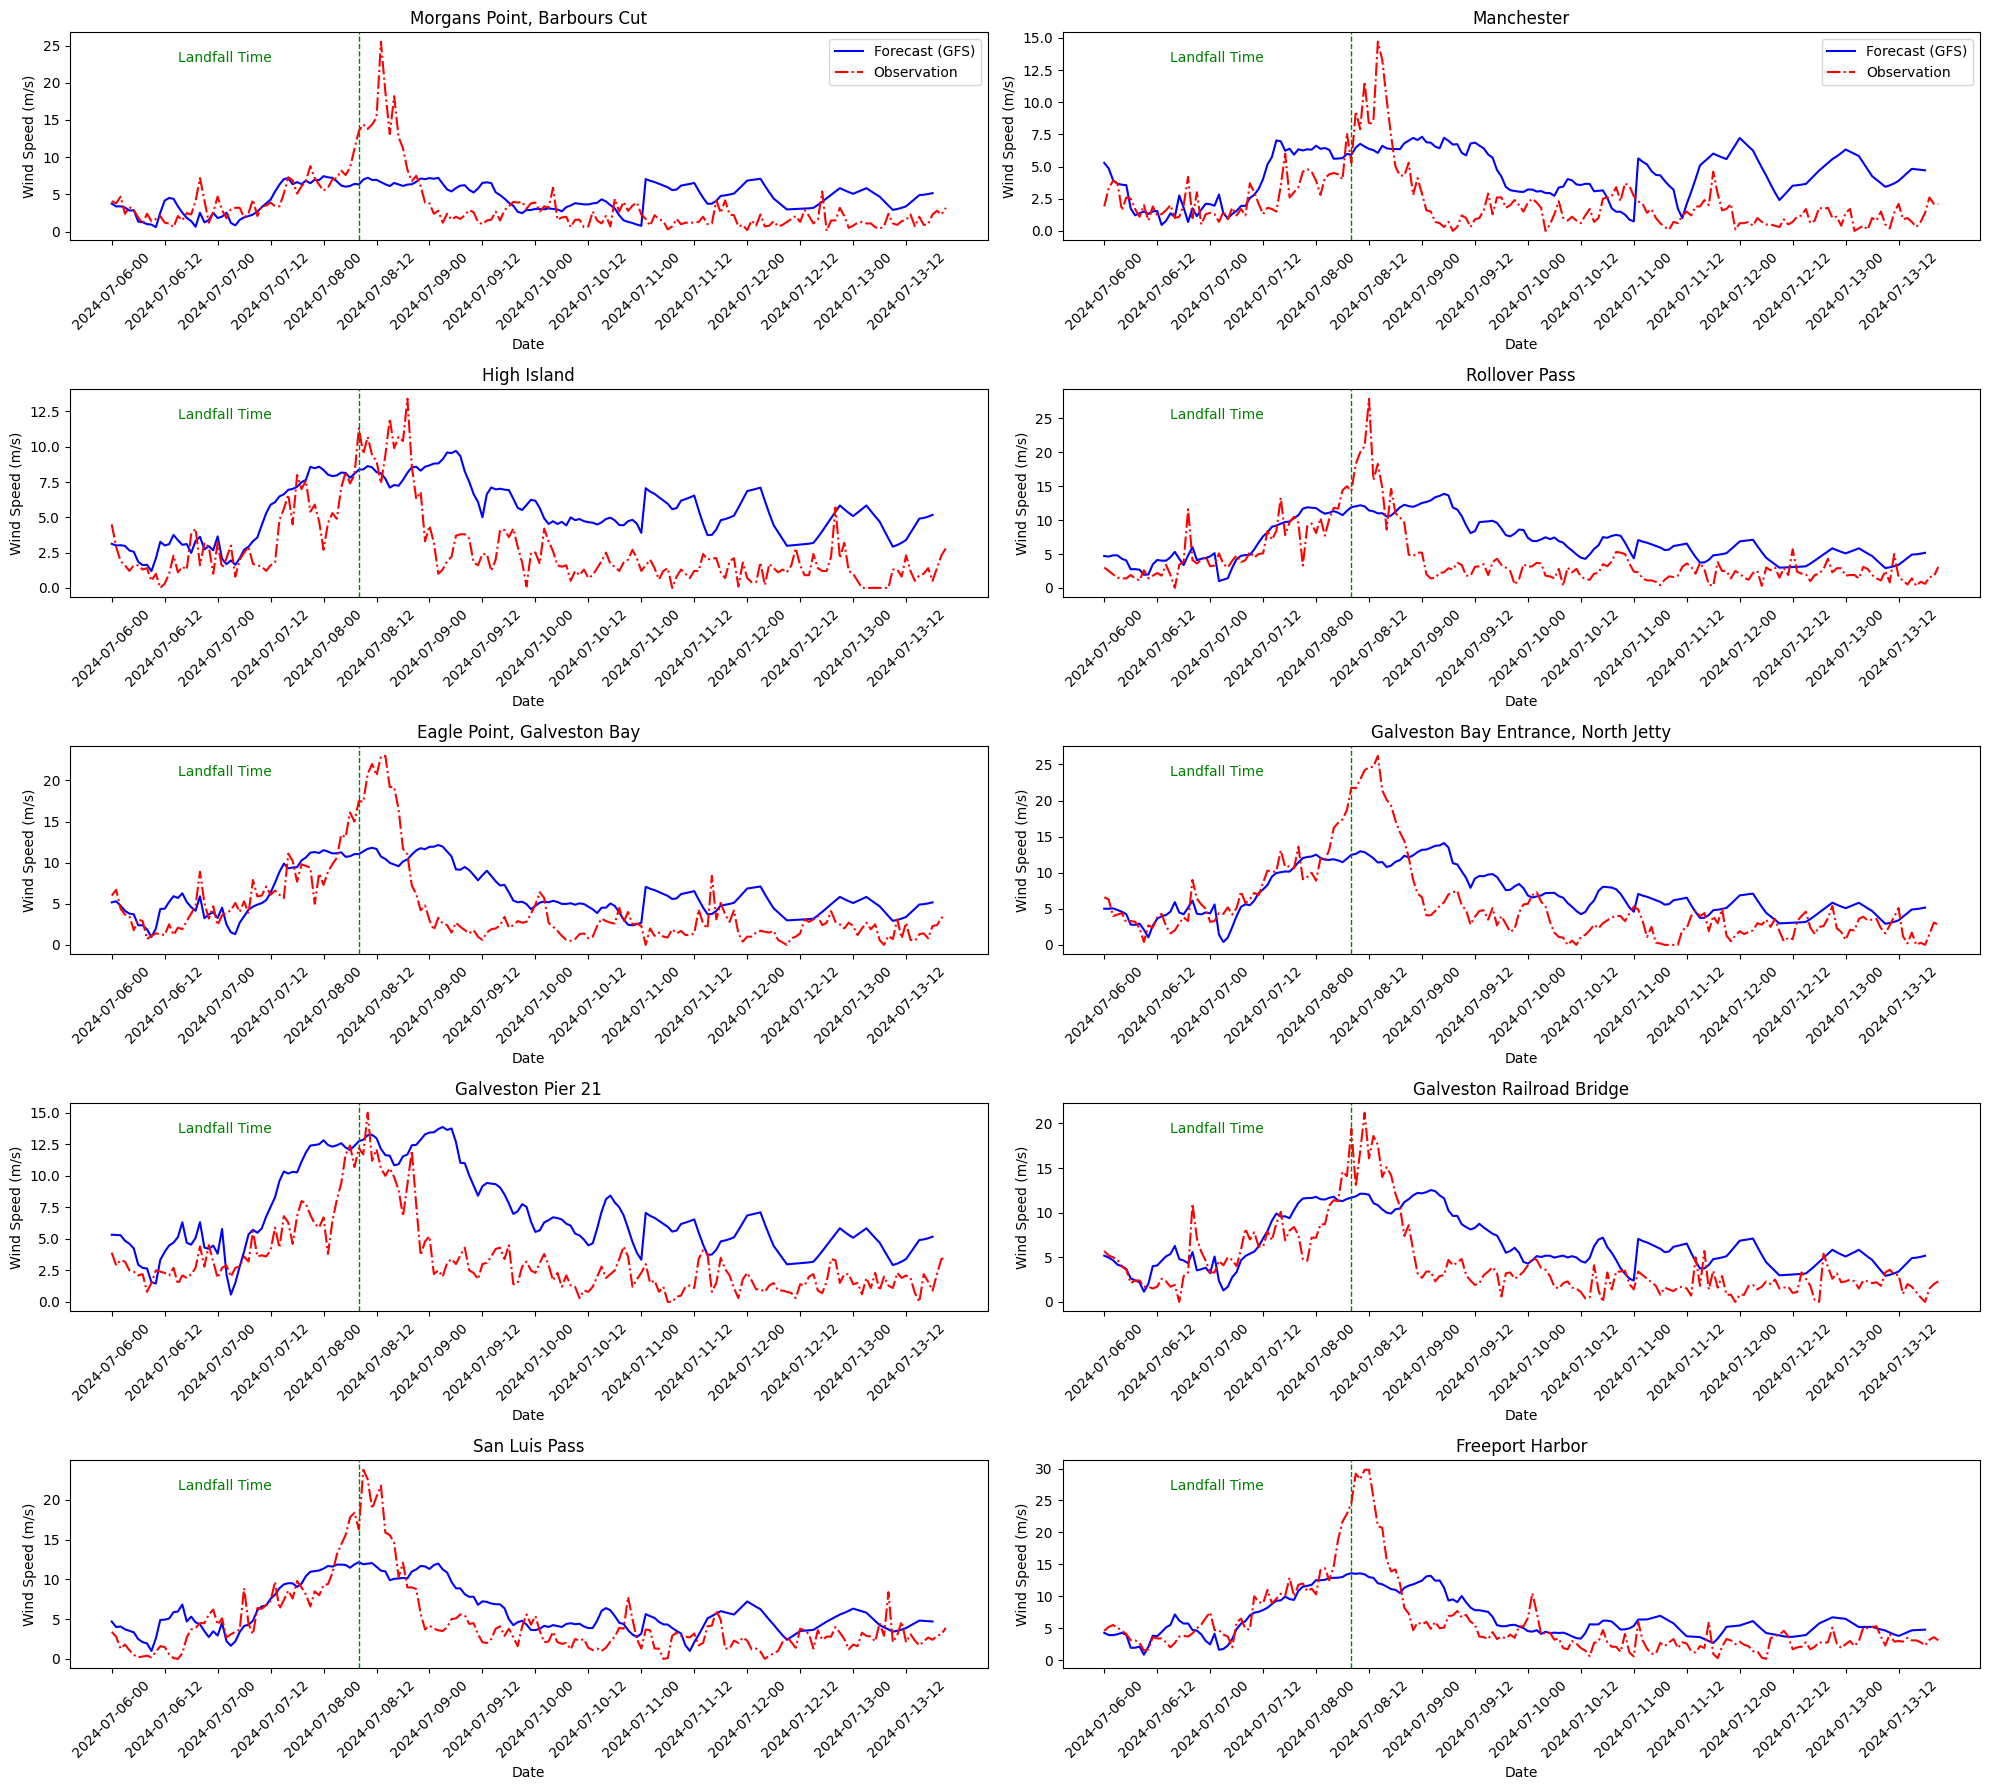

In [44]:

def convert_to_datetime(time_step):
    start_date = time_df['Time'][0]
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 2


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 18))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(wind_stations['nos_id']):
            break
        
        nos_id = wind_stations['nos_id'][index]
        ax = axs[row, col]
        
        ax.plot(np.sqrt(u_wind_dfs_forecast[int(nos_id)]**2 + v_wind_dfs_forecast[int(nos_id)]**2)[:len(Wind_Observation_2d_forecast[0])], label='Forecast (GFS)', color='blue')
        ax.plot(Wind_Observation_2d_forecast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(wind_stations['name'][index])
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_2d_forecast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_2d_forecast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]

        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        forecast_2d_landfall_time_step = None 
    
        for step, time_label in zip(time_steps, time_labels): 

            if time_label == landfall_datetime:
                 forecast_2d_landfall_time_step = step 
                 break   
        

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
        ax.axvline(x=forecast_2d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('GFS_Wind_Forecasting.png')


# Display the plot
plt.show()





# Read STOFS-3D-Atl input wind data for nowcast

In [29]:

date = date_range[0]

base_key = f'stofs_3d_atl.{date}'

filename = f'schout_adcirc_{date}.nc'
         
key = f'STOFS-3D-Atl/{base_key}/{filename}'

bucket_name = bucket_name_3d

dataset = read_netcdf_from_s3(bucket_name, key)  # the first 24 hr (240 time steps are the now cast data)


def  get_indices_of_nearest_nodes(ds: xr.Dataset, x: float, y: float, num_nodes: int ) -> List[int]:
    # https://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    # https://github.com/Unidata/python-workshop/blob/fall-2016/notebooks/netcdf-by-coordinates.ipynb
    dist = abs(ds.x - x) ** 2 + abs(ds.y - y) ** 2
    indices_of_nearest_nodes = dist.argsort()[:num_nodes]
    return indices_of_nearest_nodes.values

# Initialize an empty DataFrame to store the data
index = pd.DataFrame()

# Initialize an empty DataFrame to store the data
data = []

for nos_id, x, y in zip(wind_stations['nos_id'], wind_stations['lon'], wind_stations['lat']):
    index_values = get_indices_of_nearest_nodes(dataset, x, y,1)
    data.append({'nos_id': nos_id , 'index_value': index_values})

# Convert the list of dictionaries to a DataFrame
index = pd.DataFrame(data)
index_list = []

for i in range(0,len(index)):
  index_list.append(int(index.index_value[i][0]))

index_list

[2728409,
 2655126,
 2816795,
 2816071,
 2766792,
 2803308,
 2793225,
 2786722,
 2791329,
 2782171]

In [30]:

# Read STOFS-3d-Atlantic


bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1)  # to include all nowcast data for the specified range


dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
    current_date += timedelta(days=1)


wind_forecast_3d_all_list = []


for date in dates:
    print(date)
    base_key = f'stofs_3d_atl.{date}'
    previous_date = datetime.strptime(date, '%Y%m%d') - timedelta(days=1)
    filename = f'schout_adcirc_{previous_date.strftime("%Y%m%d")}.nc'
    key = f'STOFS-3D-Atl/{base_key}/{filename}'
    
    try:
        forecast_3d = read_netcdf_from_s3(bucket_name, key)
        
        # Calculate square root of sum of squares for uwind and vwind at specific points (nos_id)
        sqrt_uv_sum = np.sqrt(forecast_3d['uwind'][:, index_list]**2 + forecast_3d['vwind'][:, index_list]**2)
        
        # Store the result in a list
        wind_forecast_3d_all_list.append(sqrt_uv_sum)
        
    except Exception as e:
        print(f'Error reading file {key} from S3: {str(e)}')


# Concatenate all datasets along the time dimension
if wind_forecast_3d_all_list:
    wind_concat = xr.concat(wind_forecast_3d_all_list, dim='time')
else:
    print("No valid data found.")


wind_concat


20240707
20240708
20240709
20240710


<xarray.DataArray (time: 96, node: 10)> Size: 8kB
array([[1.65973281e+00, 2.91223349e+00, 3.07713624e-01, 2.69832412e-01,
        1.59629994e+00, 2.85292054e+00, 1.65567921e+00, 1.82750252e+00,
        1.38146632e+00, 2.29017791e+00],
       [7.03001520e-01, 1.93571930e+00, 5.77186289e-01, 1.19729967e+00,
        2.23539570e+00, 2.70712844e+00, 1.85402260e+00, 1.91074391e+00,
        1.40180298e+00, 1.22350819e+00],
       [1.51108582e-01, 1.48029245e+00, 2.90288885e-01, 1.49242498e+00,
        6.21820564e-01, 1.57139250e+00, 7.65296495e-01, 1.51281585e+00,
        1.22322937e+00, 1.31493949e+00],
       [2.42398784e+00, 7.93299876e-01, 2.32947466e+00, 3.38455523e+00,
        1.92971967e+00, 2.51105770e+00, 1.87892566e+00, 2.05734905e+00,
        1.98897510e+00, 2.53801047e+00],
       [4.65812953e+00, 1.44836573e+00, 4.28760586e+00, 4.82414879e+00,
        3.62414661e+00, 4.42268223e+00, 3.87076671e+00, 3.54468291e+00,
        3.10723216e+00, 3.07681181e+00],
       [4.29247719e+00, 2.31543283e+00, 4.22646363e+00, 4.43618302e+00,
        3.74535971e+00, 3.11287929e+00, 3.11425628e+00, 3.22896322e+00,
        4.20871962e+00, 3.34983991e+00],
       [4.98862564e+00, 8.27663378e+00, 7.65687625e+00, 4.90998653e+00,
        3.05312226e+00, 4.49428904e+00, 3.82924465e+00, 4.89031839e+00,
...
        2.96190185e+00, 3.24691563e+00, 2.20719075e+00, 2.65826689e+00,
        2.21481814e+00, 3.07628815e+00],
       [7.35169789e-01, 1.41329596e+00, 7.78330390e-03, 1.59780598e+00,
        2.05866591e+00, 2.21221278e+00, 2.07835979e+00, 2.87116286e+00,
        1.14574769e+00, 1.12352597e+00],
       [5.95690025e-01, 1.23988044e+00, 1.26749658e+00, 2.56996272e+00,
        1.82178717e+00, 3.50172641e+00, 2.45875979e+00, 2.75451303e+00,
        2.06865751e+00, 1.60310010e+00],
       [1.84688009e+00, 1.54156342e+00, 1.23949434e+00, 2.23884975e+00,
        2.16822646e+00, 3.15044982e+00, 2.34592706e+00, 2.47035108e+00,
        2.40000410e+00, 1.98912641e+00],
       [1.75119898e+00, 1.14937365e+00, 1.59136835e+00, 2.48953594e+00,
        3.34246586e+00, 2.86995672e+00, 2.35677103e+00, 2.35917444e+00,
        2.80194431e+00, 2.15399495e+00],
       [1.86863772e+00, 8.58707993e-01, 1.39585837e+00, 2.87588889e+00,
        2.90527075e+00, 3.12519435e+00, 2.25206936e+00, 2.54243515e+00,
        2.87312802e+00, 2.42334429e+00],
       [1.56221603e+00, 5.40193850e-01, 1.28812434e+00, 2.13208996e+00,
        1.98049754e+00, 2.25608633e+00, 1.99467732e+00, 1.79652860e+00,
        2.44470156e+00, 2.29204060e+00]])
Coordinates:
  * time     (time) datetime64[ns] 768B 2024-07-06T13:00:00 ... 2024-07-10T12...
    x        (node) float64 80B -94.99 -95.27 -94.39 ... -94.9 -95.13 -95.29
    y        (node) float64 80B 29.68 29.73 29.6 29.51 ... 29.3 29.08 28.94
Dimensions without coordinates: node

# Read Wind_observation_data for STOFS-3D-Atl

In [31]:
# Initialize an empty DataFrame to store the data
Wind_Observation_3d_nowcast= []

# Loop over each nos_id
for nos_id in wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=wind_concat['time'].values[0],
       end_date=wind_concat['time'].values[-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_3d_nowcast.append(station_wind['speed'])
Wind_Observation_3d_nowcast

/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is ret

[time
 2024-07-06 13:00:00+00:00    1.1
 2024-07-06 14:00:00+00:00    0.6
 2024-07-06 15:00:00+00:00    2.1
 2024-07-06 16:00:00+00:00    1.5
 2024-07-06 17:00:00+00:00    2.5
                             ... 
 2024-07-10 08:00:00+00:00    0.6
 2024-07-10 09:00:00+00:00    1.6
 2024-07-10 10:00:00+00:00    1.6
 2024-07-10 11:00:00+00:00    0.6
 2024-07-10 12:00:00+00:00    0.7
 Name: speed, Length: 96, dtype: float64,
 time
 2024-07-06 13:00:00+00:00    1.3
 2024-07-06 14:00:00+00:00    1.6
 2024-07-06 15:00:00+00:00    2.0
 2024-07-06 16:00:00+00:00    1.0
 2024-07-06 17:00:00+00:00    1.1
                             ... 
 2024-07-10 08:00:00+00:00    1.0
 2024-07-10 09:00:00+00:00    0.8
 2024-07-10 10:00:00+00:00    1.1
 2024-07-10 11:00:00+00:00    0.8
 2024-07-10 12:00:00+00:00    0.6
 Name: speed, Length: 96, dtype: float64,
 time
 2024-07-06 13:00:00+00:00    1.0
 2024-07-06 14:00:00+00:00    2.3
 2024-07-06 15:00:00+00:00    1.1
 2024-07-06 16:00:00+00:00    1.5
 2024-07-06 17

# Plot Wind nowcast data for STOFS-3D-Atl

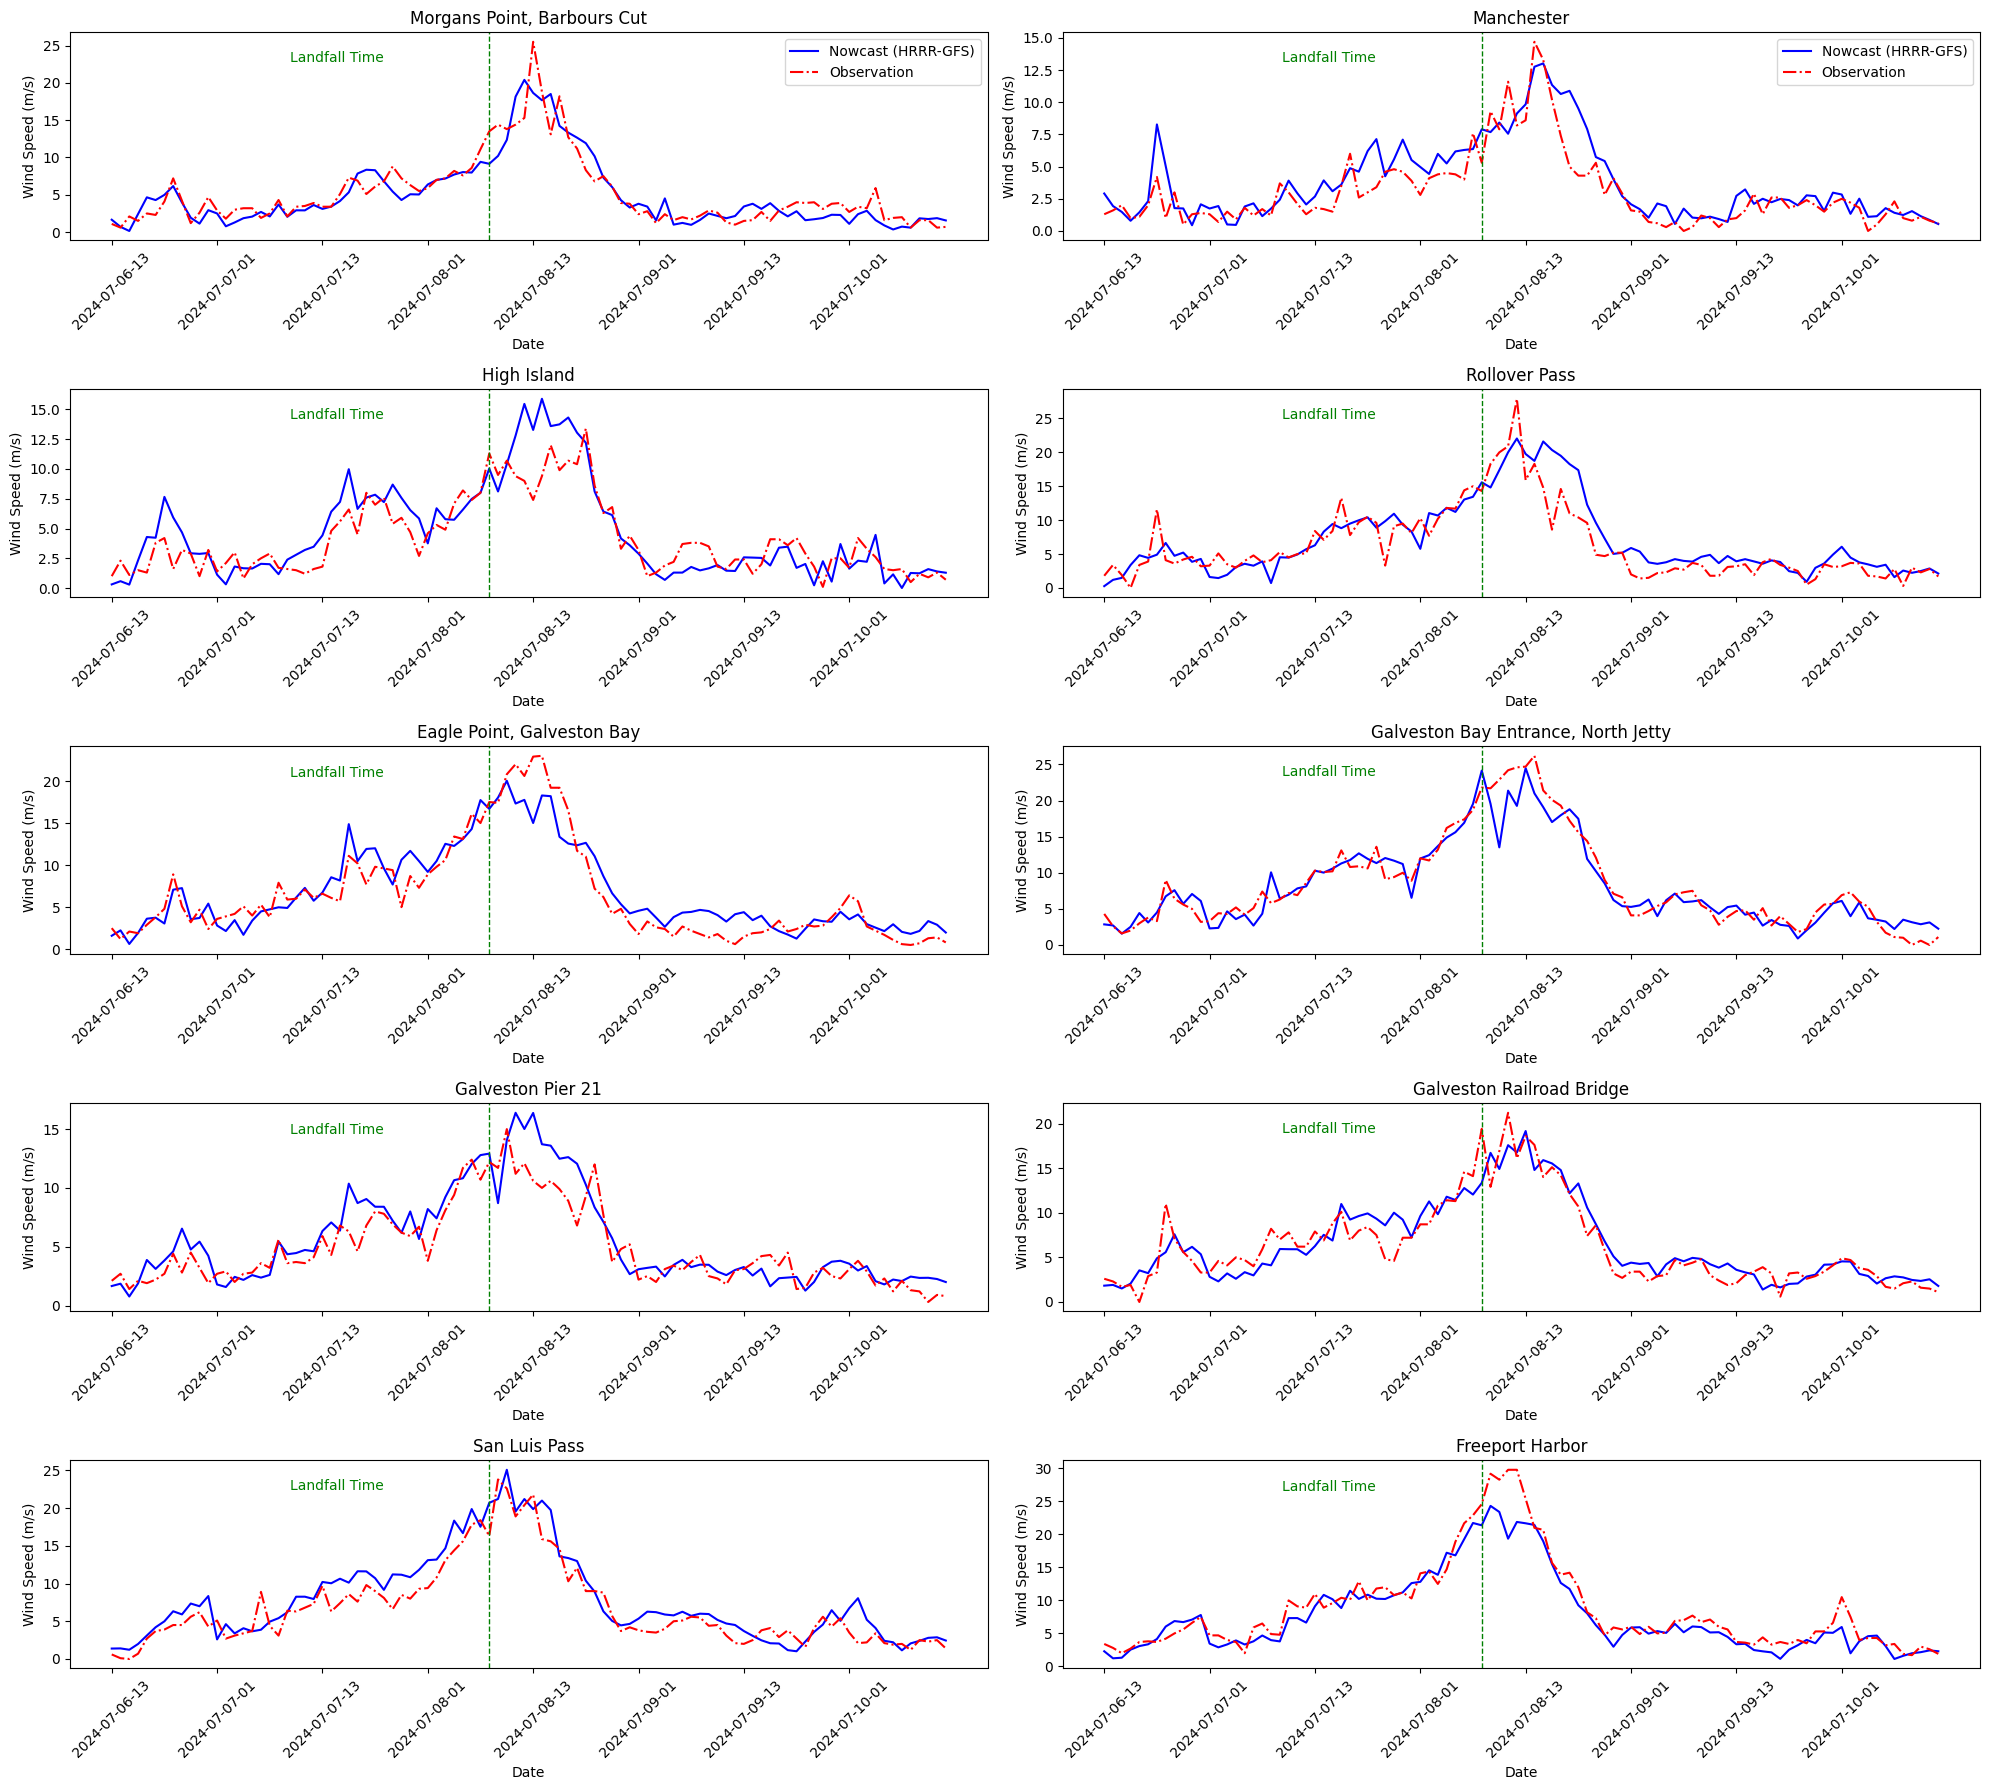

In [32]:

def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(wind_concat['time'].values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 2


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 18))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(wind_stations['nos_id']):
            break
        
        nos_id = wind_stations['nos_id'][index]
        ax = axs[row, col]
        
        ax.plot(wind_concat[:,index], label='Nowcast (HRRR-GFS)', color='blue')
        ax.plot(Wind_Observation_3d_nowcast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(wind_stations['name'][index])
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_3d_nowcast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_3d_nowcast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        
        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        nowcast_3d_landfall_time_step = None 

        for step, time_label in zip(time_steps, time_labels): 

            if time_label.replace(tzinfo = None) == landfall_datetime:
               nowcast_3d_landfall_time_step = step 
               break 

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        ax.axvline(x=nowcast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('STOFS_3D_Wind_Nowcast.png')

# Display the plot
plt.show()




# Read wind Forecast from STOFS-3D-Atl

In [33]:
# Read STOFS-3d-Atlantic


bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = start_date + timedelta(days=5) # Forecast data provided in each STOFS-3D-Atl cycle


# Find the forecast date

dates = []

forecast_date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')

current_date = datetime.strptime(forecast_date, '%Y%m%d')-timedelta(days=1) #starting from nowcast data
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
    current_date += timedelta(days=1)


wind_forecast_3d_all_list = []

for date in dates:
    print(date)
    base_key = f'stofs_3d_atl.{forecast_date}'
    filename = f'schout_adcirc_{date}.nc'
    key = f'STOFS-3D-Atl/{base_key}/{filename}'
    
    try:
        wind_forecast_3d = read_netcdf_from_s3(bucket_name, key)
        
        # Calculate square root of sum of squares for uwind and vwind at specific points (nos_id)
        sqrt_uv_sum = np.sqrt(wind_forecast_3d['uwind'][:, index_list]**2 + wind_forecast_3d['vwind'][:, index_list]**2)
        
        # Store the result in a list
        wind_forecast_3d_all_list.append(sqrt_uv_sum)
        
    except Exception as e:
        print(f'Error reading file {key} from S3: {str(e)}')


# Concatenate all datasets along the time dimension
if wind_forecast_3d_all_list:
    wind_concat_forecast = xr.concat(wind_forecast_3d_all_list, dim='time')
else:
    print("No valid data found.")


wind_concat_forecast


20240705
20240706
20240707
20240708
20240709
20240710
Error reading file STOFS-3D-Atl/stofs_3d_atl.20240706/schout_adcirc_20240710.nc from S3: noaa-nos-stofs3d-pds/STOFS-3D-Atl/stofs_3d_atl.20240706/schout_adcirc_20240710.nc
20240711
Error reading file STOFS-3D-Atl/stofs_3d_atl.20240706/schout_adcirc_20240711.nc from S3: noaa-nos-stofs3d-pds/STOFS-3D-Atl/stofs_3d_atl.20240706/schout_adcirc_20240711.nc
20240712
Error reading file STOFS-3D-Atl/stofs_3d_atl.20240706/schout_adcirc_20240712.nc from S3: noaa-nos-stofs3d-pds/STOFS-3D-Atl/stofs_3d_atl.20240706/schout_adcirc_20240712.nc


<xarray.DataArray (time: 120, node: 10)> Size: 10kB
array([[2.47256553, 1.62061295, 1.22999095, ..., 1.76456422, 3.84291544,
        4.77440673],
       [2.81478902, 2.5413163 , 2.06098031, ..., 1.92552058, 3.07912615,
        3.91815513],
       [2.76736397, 2.84905881, 2.14133092, ..., 3.60371321, 2.70300291,
        3.20766278],
       ...,
       [1.9291341 , 1.11882128, 2.57742622, ..., 2.58614884, 2.12445162,
        1.54964922],
       [2.12604789, 1.57110426, 3.03637706, ..., 3.54885839, 3.03616651,
        2.47524588],
       [2.29296634, 1.63208489, 3.4760193 , ..., 3.96209582, 3.3561686 ,
        2.90150135]])
Coordinates:
  * time     (time) datetime64[ns] 960B 2024-07-05T13:00:00 ... 2024-07-10T12...
    x        (node) float64 80B -94.99 -95.27 -94.39 ... -94.9 -95.13 -95.29
    y        (node) float64 80B 29.68 29.73 29.6 29.51 ... 29.3 29.08 28.94
Dimensions without coordinates: node

# Read Observation data for forecast wind

In [34]:
# Initialize an empty DataFrame to store the data
Wind_Observation_3d_forecast= []

# Loop over each nos_id
for nos_id in wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=wind_concat_forecast['time'].values[0],
       end_date=wind_concat_forecast['time'].values[-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_3d_forecast.append(station_wind['speed'])
Wind_Observation_3d_forecast

/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is ret

[time
 2024-07-05 13:00:00+00:00    1.5
 2024-07-05 14:00:00+00:00    1.7
 2024-07-05 15:00:00+00:00    4.2
 2024-07-05 16:00:00+00:00    2.9
 2024-07-05 17:00:00+00:00    3.2
                             ... 
 2024-07-10 08:00:00+00:00    0.6
 2024-07-10 09:00:00+00:00    1.6
 2024-07-10 10:00:00+00:00    1.6
 2024-07-10 11:00:00+00:00    0.6
 2024-07-10 12:00:00+00:00    0.7
 Name: speed, Length: 120, dtype: float64,
 time
 2024-07-05 13:00:00+00:00    0.8
 2024-07-05 14:00:00+00:00    1.6
 2024-07-05 15:00:00+00:00    1.9
 2024-07-05 16:00:00+00:00    1.2
 2024-07-05 17:00:00+00:00    2.8
                             ... 
 2024-07-10 08:00:00+00:00    1.0
 2024-07-10 09:00:00+00:00    0.8
 2024-07-10 10:00:00+00:00    1.1
 2024-07-10 11:00:00+00:00    0.8
 2024-07-10 12:00:00+00:00    0.6
 Name: speed, Length: 120, dtype: float64,
 time
 2024-07-05 13:00:00+00:00    2.5
 2024-07-05 14:00:00+00:00    2.1
 2024-07-05 15:00:00+00:00    3.4
 2024-07-05 16:00:00+00:00    3.4
 2024-07-05 

# Plot wind forecast for STOFS-3D-Atl

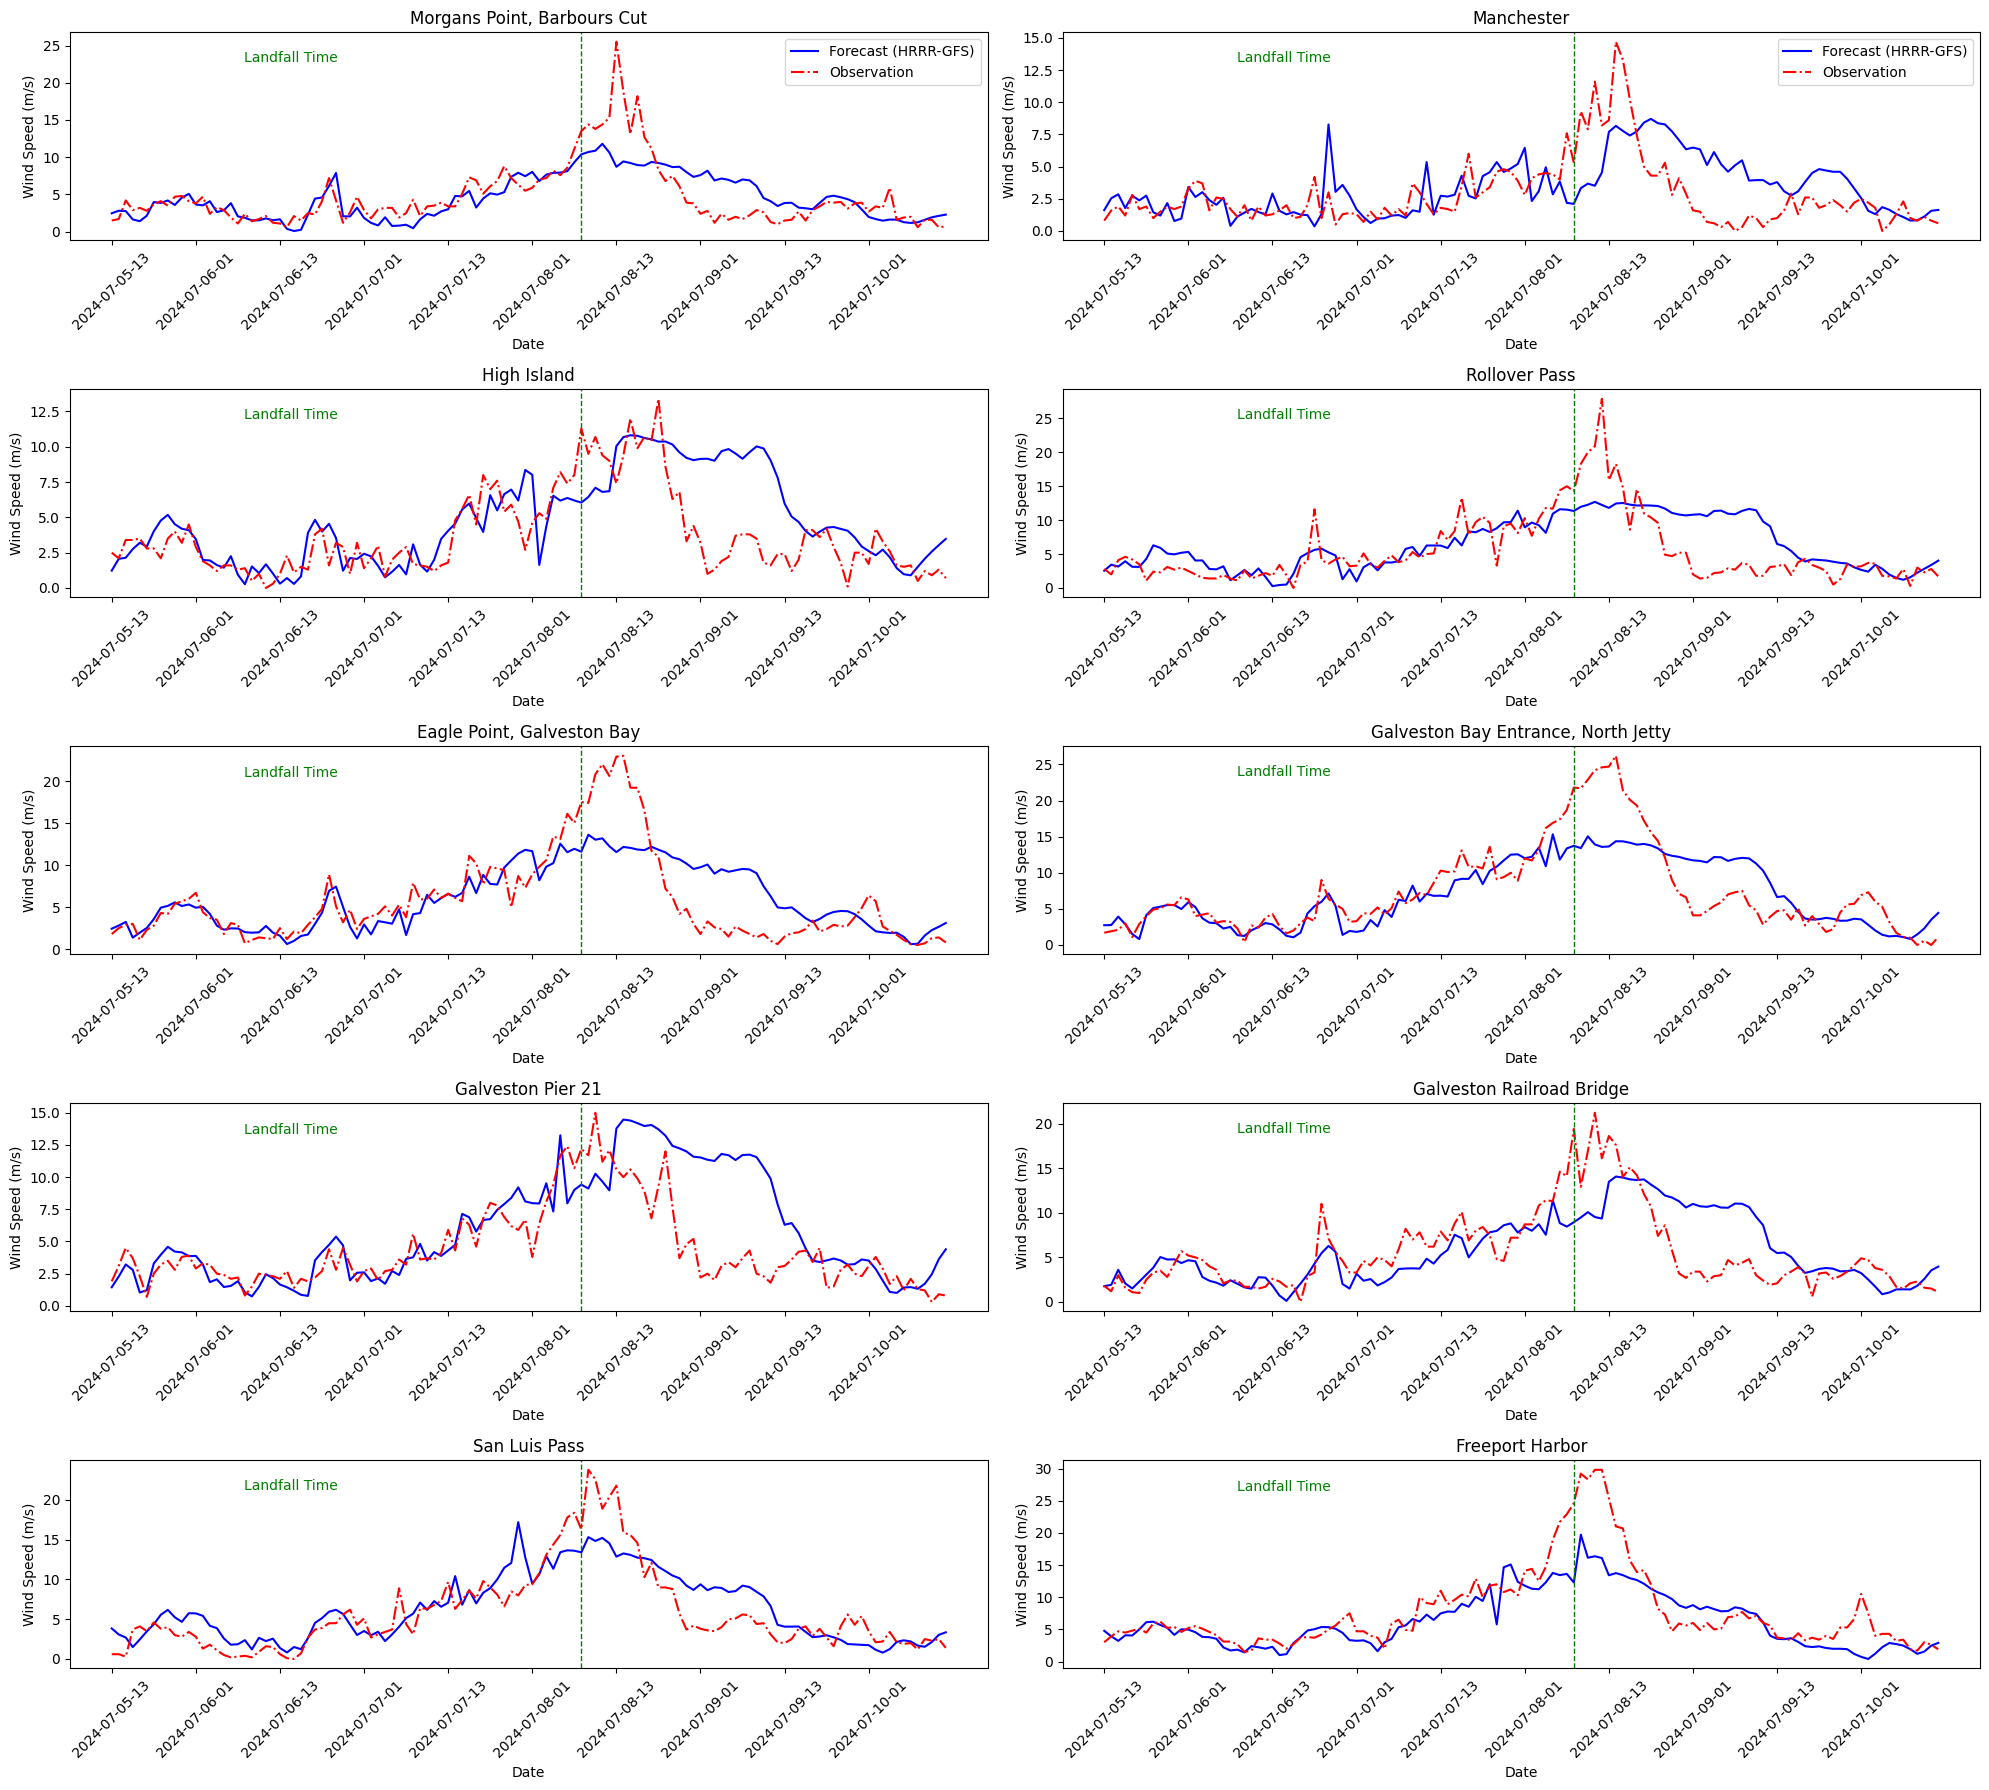

In [35]:
def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(wind_concat_forecast['time'].values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 2


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 18))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(wind_stations['nos_id']):
            break
        
        nos_id = wind_stations['nos_id'][index]
        ax = axs[row, col]
        
        ax.plot(wind_concat_forecast[:,index], label='Forecast (HRRR-GFS)', color='blue')
        ax.plot(Wind_Observation_3d_forecast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(wind_stations['name'][index])
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_3d_forecast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_3d_forecast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        
        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        forecast_3d_landfall_time_step = None 

        for step, time_label in zip(time_steps, time_labels): 

            if time_label.replace(tzinfo = None) == landfall_datetime:
               forecast_3d_landfall_time_step = step 
               break 

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        ax.axvline(x=forecast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('STOFS_3D_Wind_forecast.png')

# Display the plot
plt.show()
